In [176]:
import os
import h5py
from scipy.io import loadmat
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from preproc import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle

In [177]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [178]:
# Save directory for figures and data files
figsave_dir = f'figures/{day_dir}/decoding'
datasave_dir = f'data/decoding'

### Preprocessing of rplparallel, spiketrain, vmpv, raycast data

In [179]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp_file = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp_file.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.round(np.array(rp.get('timeStamps')), 3)
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)
rp_file.close()

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    try:
        spk_file = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except NotImplementedError:
        spk_file = h5py.File(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except FileNotFoundError:
        continue
    spk = np.array(spk_file.get('timestamps')).flatten() # spike timestamps is loaded in as a column vector
    spk /= 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    if isinstance(spk_file, h5py.File):
        spk_file.close()
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv_file = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv_file.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)
pv_file.close()

# Load data from binData.hdf object, extract view bin data
viewbin_data = np.genfromtxt(prefix + day_dir + "/session01/1binData.csv", delimiter=',')
viewbin_data[:,0] /= 1000 # convert eyelink timestamps from msec to sec

In [180]:
# Define important constants
num_cells = len(cell_labels)
num_goals = 6
tbin_size = 0.001

In [181]:
# Get trial outcomes from trial markers
# 0 for unsuccessful trials, 1 for successful trials
trial_outcomes = 4 - trial_markers[2,:] // 10
trial_outcomes = trial_outcomes.astype(int)

# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Get durations of each navigation phase
nav_intervals = trial_timestamps[1:,:].T
nav_durations = nav_intervals[:,1] - nav_intervals[:,0]

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

# Further differentiate trial markers into trial trajectories (start poster, end poster)
trial_trajectories = np.zeros((trial_markers.shape[0], 2))
trial_trajectories[:,1] = trial_markers
trial_trajectories[1:,0] = trial_markers[:-1]

In [182]:
# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(trial_markers.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(nav_durations):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_outcomes = trial_outcomes[trial_filt]
trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt]
nav_intervals = nav_intervals[trial_filt]
nav_durations = nav_durations[trial_filt]
trial_intervals = trial_intervals[trial_filt]
trial_trajectories = trial_trajectories[trial_filt]

Cue phase data

In [183]:
# Extract periods in cue phase where cue image was not looked at
# Preallocate list of arrays for spike counts per time bin in cue phase
cueimg_filter = list()
timebins_cue = list()
spikecounts_cue = list()
for trial in cue_intervals:
    st_time, ed_time = trial
    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]
    cueimg_filter.append(viewbin_data_trial[:,1] == 1)
    timebins_cue.append(np.hstack([viewbin_data_trial[:,0].reshape(-1,1), viewbin_data_trial[:,0].reshape(-1,1)+tbin_size]))
    spikecounts_cue.append(np.zeros((viewbin_data_trial.shape[0], num_cells)))

# Slot spikes into cue phase intervals, using time bin resolution same as eyelink/raycasting data (i.e. 1 ms)
# Also filter out time bins where cue image was not looked at
for i, trial in enumerate(timebins_cue):
    spikecounts_cue[i] = np.array(spike_counts_per_observation(trial, spike_times))
    spikecounts_cue[i] = spikecounts_cue[i][cueimg_filter[i]]

# Convert spike counts to average spike rates across duration of cue phase
spikerates_cue = np.empty((len(spikecounts_cue), num_cells))
spikerates_cue[:,:] = np.nan
for i, trial in enumerate(spikecounts_cue):
    if timebins_cue[i].shape[0] > 0:
        spikerates_cue[i,:] = np.sum(trial, axis=0)/(tbin_size*timebins_cue[i].shape[0])

# Filter out trials with nans in cue spike rates
goals_cue = trial_markers.copy()
trajectories_cue = trial_trajectories.copy()
cue_filter = np.all(~np.isnan(spikerates_cue),axis=1)
spikerates_cue = spikerates_cue[cue_filter,:]
goals_cue = goals_cue[cue_filter]
trajectories_cue = trajectories_cue[cue_filter]


Hint viewing data

In [184]:
# Grab periods in the navigation phase when the hint image was looked at
# As well as which goal it corresponded to
def chunk_into_intervals(timepts: np.array, tbin: float=0.001) -> np.array:
    intervals = list()
    i, st = 0, None
    while i < timepts.shape[0]:
        curr = timepts[i]
        if st is None:
            st = curr
        elif curr > prev + 1.1 * tbin:
            intervals.append(np.array([st, prev+tbin]))
            st = curr
        prev = curr
        i += 1
    if st is not None:
        intervals.append(np.array([st, prev+tbin]))
    return np.array(intervals)

timebins_hints = list()
spikecounts_hints = list()
for trial in nav_intervals:
    st_time, ed_time = trial
    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]
    hint_periods_trial = chunk_into_intervals(viewbin_data_trial[viewbin_data_trial[:,1] == 2, 0])
    timebins_hints.append(hint_periods_trial)
    spikecounts_hints.append(np.zeros((hint_periods_trial.shape[0], num_cells)))

# Slot spikes into hint viewing periods
for i, trial in enumerate(timebins_hints):
    spikecounts_hints[i] = np.array(spike_counts_per_observation(trial, spike_times))

'''
# Convert spike counts into spike rates per instance of hint viewing
spikerates_hints = list()
for i, trial in enumerate(spikecounts_hints):
    trial_spikerates = np.empty((len(trial), num_cells))
    trial_spikerates[:,:] = np.nan
    if timebins_hints[i].shape[0] > 0:
        trial_spikerates = trial/(timebins_hints[i][:,1]-timebins_hints[i][:,0])[:,np.newaxis]
    spikerates_hints.append(trial_spikerates)
'''

# Convert spike counts to average spike rates across all hint viewing instances per trial
spikerates_hints = np.empty((len(spikecounts_hints), num_cells))
spikerates_hints[:,:] = np.nan
for i, trial in enumerate(spikecounts_hints):
    if timebins_hints[i].shape[0] > 0:
        spikerates_hints[i,:] = np.sum(trial, axis=0)/np.sum(timebins_cue[i][:,1]-timebins_cue[i][:,0])

'''
# Flatten hint spike rates into a single long array containing all instances across trials
goals_hints = list()
for i, goal in enumerate(trial_markers):
    goals_hints.extend(spikerates_hints[i].shape[0]*[goal])
goals_hints = np.array(goals_hints)
trajectories_hints = list()
for i, traj in enumerate(trial_trajectories):
    trajectories_hints.extend([traj for _ in range(spikerates_hints[i].shape[0])])
trajectories_hints = np.array(trajectories_hints)
spikerates_hints = np.vstack(spikerates_hints)
'''
goals_hints = trial_markers.copy()
trajectories_hints = trial_trajectories.copy()

# Filter out trials with nans in hint spike rates
hints_filter = np.all(~np.isnan(spikerates_hints),axis=1)
spikerates_hints = spikerates_hints[hints_filter,:]
goals_hints = goals_hints[hints_filter]
trajectories_hints = trajectories_hints[hints_filter]

Navigation end (last second) data

In [185]:
# View bins for all of the posters on the pillar walls
poster_viewbins = np.concatenate([np.arange(4533,4536+1), np.arange(4565,4568+1), np.arange(4597,4600+1), np.arange(4685,4688+1), np.arange(4717,4720+1), np.arange(4749,4752+1),\
                                    np.arange(4701,4704+1), np.arange(4733,4736+1), np.arange(4765,4768+1), np.arange(4845,4848+1), np.arange(4877,4480+1), np.arange(4909,4912+1),\
                                        np.arange(4861,4864+1), np.arange(4893,4896+1), np.arange(4925,4928+1), np.arange(4997,5000+1), np.arange(5029,5032+1), np.arange(5061,5064+1)])
poster_viewbins = set(poster_viewbins)

# Get last 1 second of navigation phases, but filter out unsuccessful trials
one_second = 1
successful_trials = np.where(trial_outcomes == 1)
'''
timebins_navend = np.hstack([nav_intervals[:,1].reshape(-1,1)-one_second, nav_intervals[:,1].reshape(-1,1)])
timebins_navend = timebins_navend[successful_trials]

# Slot spikes into navend phases
spikecounts_navend = spike_counts_per_observation(timebins_navend, spike_times)

# Convert spike counts into spike rates for navend phases (no need conversion since we are just dividing by 1 second)
spikerates_navend = spikecounts_navend.copy()
'''

# Filter out time points in the 1 second where the poster was not looked at
poster_filter = list()
timebins_navend = list()
spikecounts_navend = list()
for trial in nav_intervals:
    st_time, ed_time = trial
    st_time = ed_time - one_second
    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]
    poster_filter.append(np.array([viewbin_data_trial[i,1] in poster_viewbins for i in range(viewbin_data_trial.shape[0])]))
    timebins_navend.append(np.hstack([viewbin_data_trial[:,0].reshape(-1,1), viewbin_data_trial[:,0].reshape(-1,1)+tbin_size]))
    spikecounts_navend.append(np.zeros((viewbin_data_trial.shape[0], num_cells)))

# Slot spikes into navend intervals, using time bin resolution same as eyelink/raycasting data (i.e. 1 ms)
# Also filter out time bins where poster was not looked at
for i, trial in enumerate(timebins_navend):
    spikecounts_navend[i] = np.array(spike_counts_per_observation(trial, spike_times))
    if poster_filter[i].shape[0] > 0:
        spikecounts_navend[i] = spikecounts_navend[i][poster_filter[i]]

# Convert spike counts to average spike rates across duration of cue phase
spikerates_navend = np.empty((len(spikecounts_navend), num_cells))
spikerates_navend[:,:] = np.nan
for i, trial in enumerate(spikecounts_navend):
    if timebins_navend[i].shape[0] > 0:
        spikerates_navend[i,:] = np.sum(trial, axis=0)/(tbin_size*timebins_navend[i].shape[0])

# Filter out trials with nans in navend spike rates
goals_navend = trial_markers.copy()
trajectories_navend = trial_trajectories.copy()
navend_filter = np.all(~np.isnan(spikerates_navend),axis=1)
spikerates_navend = spikerates_navend[navend_filter,:]
goals_navend = goals_navend[navend_filter]
trajectories_navend = trajectories_navend[navend_filter]

Plots for visualizing time bin durations, spike rates

956.7116883116884

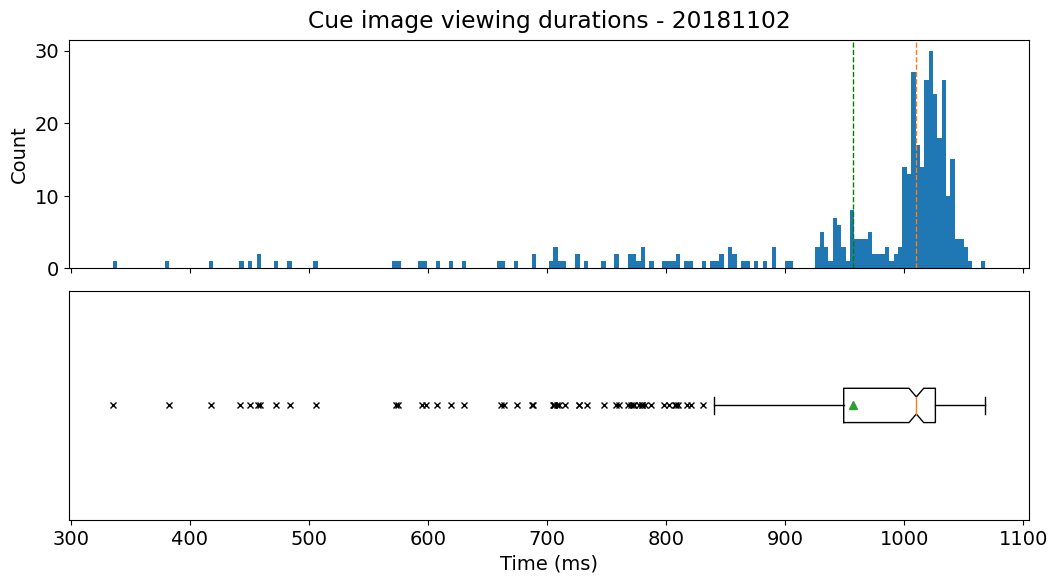

In [186]:
# Distribution of cue phase durations when the cue image was looked at
durs_cue = np.array(list(map(lambda arr: arr.shape[0], timebins_cue)))

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Cue image viewing durations - {day_dir}', y=0.95)

axes[0].hist(durs_cue, bins=200)
axes[0].axvline(x=np.mean(durs_cue), color='green', linewidth=1, linestyle='--')
axes[0].axvline(x=np.median(durs_cue), color='C1', linewidth=1, linestyle='--')
axes[0].set_ylabel('Count')

axes[1].boxplot(durs_cue, showmeans=True, notch=True, vert=False, flierprops={'marker': 'x', 'markersize': 4})
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks([])

np.mean(durs_cue)

113.96734854456653

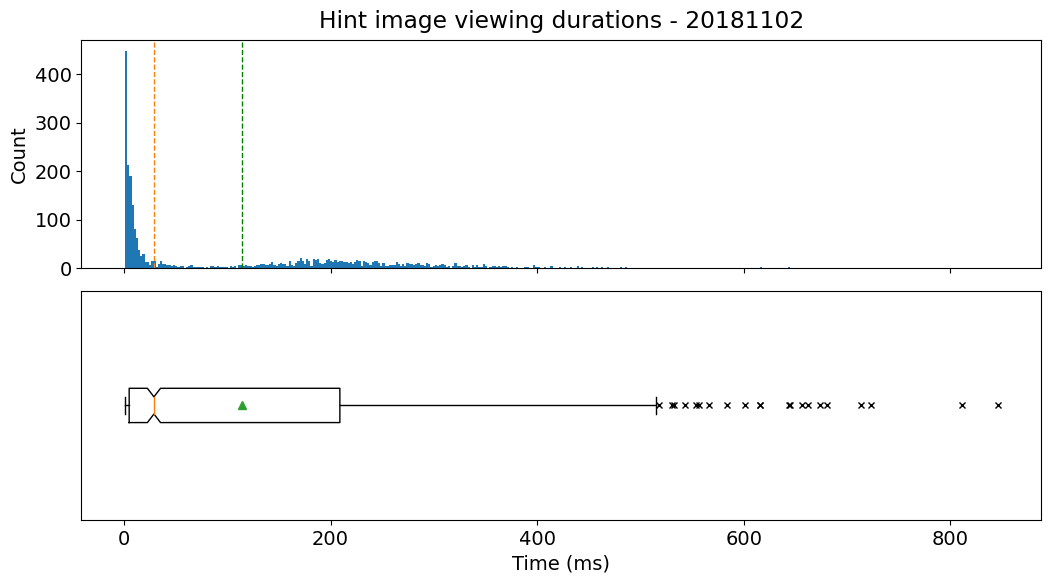

In [187]:
# Distribution of durations when the hint image was looked at
durs_hints = list()
for trial in timebins_hints:
    for obs in trial:
        st_time, ed_time = obs
        durs_hints.append(1000*(ed_time-st_time))
durs_hints = np.array(durs_hints)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Hint image viewing durations - {day_dir}', y=0.95)

axes[0].hist(durs_hints, bins=400)
axes[0].axvline(x=np.mean(durs_hints), color='green', linewidth=1, linestyle='--')
axes[0].axvline(x=np.median(durs_hints), color='C1', linewidth=1, linestyle='--')
axes[0].set_ylabel('Count')

axes[1].boxplot(durs_hints, showmeans=True, notch=True, vert=False, flierprops={'marker': 'x', 'markersize': 4})
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks([])

np.mean(durs_hints)

959.3402597402597

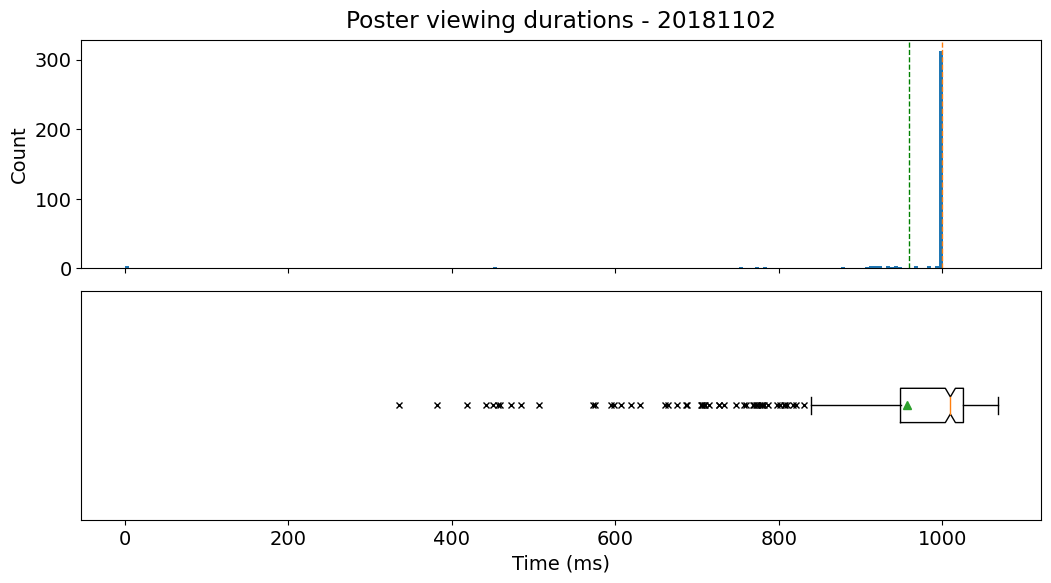

In [188]:
# Distribution of nav end durations when the poster was looked at
durs_navend = np.array(list(map(lambda arr: arr.shape[0], timebins_navend)))

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Poster viewing durations - {day_dir}', y=0.95)

axes[0].hist(durs_navend, bins=200)
axes[0].axvline(x=np.mean(durs_navend), color='green', linewidth=1, linestyle='--')
axes[0].axvline(x=np.median(durs_navend), color='C1', linewidth=1, linestyle='--')
axes[0].set_ylabel('Count')

axes[1].boxplot(durs_cue, showmeans=True, notch=True, vert=False, flierprops={'marker': 'x', 'markersize': 4})
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks([])

np.mean(durs_navend)

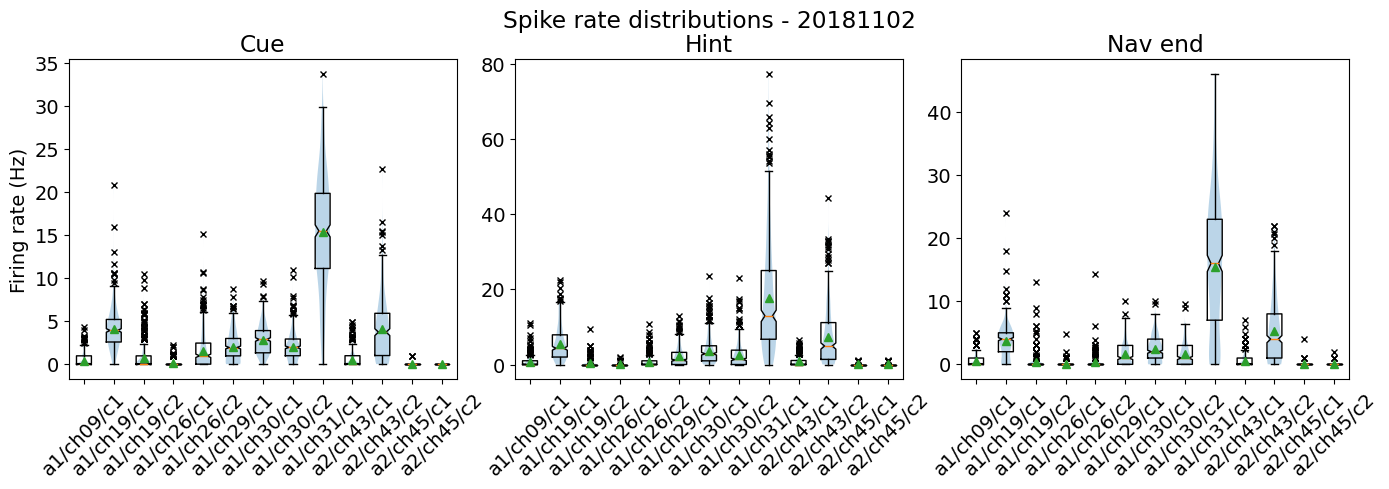

In [189]:
# Distribution of cue/hint/navend phase spike rates
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Spike rate distributions - {day_dir}', y=1.025)

axes[0].set_title('Cue')
axes[0].boxplot(spikerates_cue, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
axes[0].violinplot(spikerates_cue, showextrema=False)
axes[0].set_xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)
axes[0].set_ylabel('Firing rate (Hz)')

axes[1].set_title('Hint')
axes[1].boxplot(spikerates_hints, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
axes[1].violinplot(spikerates_hints, showextrema=False)
axes[1].set_xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)

axes[2].set_title('Nav end')
axes[2].boxplot(spikerates_navend, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
axes[2].violinplot(spikerates_navend, showextrema=False)
axes[2].set_xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)

### Cue/Hint/Navend phase, goal response decoding

In [190]:
class ResponseClassifier():
    def __init__(self, model):
        self.model = model

    def fit(self, X, y, thresh):
        self.model.fit(X, y)
        self.thresh = thresh

    def set_thresh(self, thresh):
        self.thresh = thresh

    def predict(self, X):
        classes = self.model.predict(X)
        probs = self.model.predict_proba(X)
        filt = np.where(np.max(probs, axis=1) < self.thresh)
        classes[filt] = 0
        return classes


def train_test_split(X: np.array, y: np.array, split: tuple) -> tuple:
    # itr: current iteration of k-fold validation
    # way: value of k in k-fold validation
    itr, way = split
    X_train, X_test = list(), list()
    y_train, y_test = list(), list()
    for num, obs in enumerate(X):
        if num % way == itr:
            X_test.append(obs)
            y_test.append(y[num])
        else:
            X_train.append(obs)
            y_train.append(y[num])
    # Return format: X_train, X_test, y_train, y_test   
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

def confusion_matrix(y_pred: np.array, y_actl: np.array, num_classes: int) -> np.array:
    res = np.zeros((num_classes, num_classes), dtype=int)
    for pred, actl in zip(y_pred, y_actl):
        pred, actl = int(pred - 1), int(actl - 1)
        res[pred, actl] += 1
    return res

def prediction_accuracy(y_pred: np.array, y_actl: np.array) -> float:
    count, total = 0, y_actl.shape[0]
    for num, obs in enumerate(y_pred):
        if obs == y_actl[num]:
            count += 1
    return count / total

Goal decoding

In [191]:
# Build decoder for 6+1 classes
k_fold = 10
probmins_goal = np.zeros(k_fold)
accuracy_goal_cue = np.zeros(k_fold)
confusion_goal_cue = np.zeros((num_goals, num_goals))
models_goal = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(spikerates_cue, goals_cue, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    probmins_goal[i] = np.min(y_pred_proba)
    accuracy_goal_cue[i] = prediction_accuracy(y_pred, y_test)
    confusion_goal_cue += confusion_matrix(y_pred, y_test, num_goals)
    models_goal.append(lda)

# Fit models using each fold of data
confusion_goal_hints, confusion_goal_navend = np.zeros((num_goals+1, num_goals+1)), np.zeros((num_goals+1, num_goals+1))
accuracy_goal_hints, accuracy_goal_navend = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(models_goal):
    models_goal[i] = ResponseClassifier(model)
    models_goal[i].set_thresh(probmins_goal[i])

    # Prediction on hint viewing phases
    hints_preds = model.predict(spikerates_hints)
    confusion_goal_hints += confusion_matrix(hints_preds, goals_hints, num_goals+1)
    accuracy_goal_hints[i] = prediction_accuracy(hints_preds, goals_hints)

    # Prediction on navend phases
    navend_preds = model.predict(spikerates_navend)
    confusion_goal_navend += confusion_matrix(navend_preds, goals_navend, num_goals+1)
    accuracy_goal_navend[i] = prediction_accuracy(navend_preds, goals_navend)

Starting position decoding

In [192]:
# Build decoder for 6+1 classes
k_fold = 10
probmins_start = np.zeros(k_fold)
accuracy_start_cue = np.zeros(k_fold)
confusion_start_cue = np.zeros((num_goals, num_goals))
models_start = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(spikerates_cue[1:,:], goals_cue[:-1], (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    probmins_start[i] = np.min(y_pred_proba)
    accuracy_start_cue[i] = prediction_accuracy(y_pred, y_test)
    confusion_start_cue += confusion_matrix(y_pred, y_test, num_goals)
    models_start.append(lda)

# Fit models using each fold of data
confusion_start_hints, confusion_start_navend = np.zeros((num_goals+1, num_goals+1)), np.zeros((num_goals+1, num_goals+1))
accuracy_start_hints, accuracy_start_navend = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(models_start):
    models_start[i] = ResponseClassifier(model)
    models_start[i].set_thresh(probmins_start[i])

    # Prediction on hint viewing phases
    hints_preds = model.predict(spikerates_hints[1:,:])
    confusion_start_hints += confusion_matrix(hints_preds, goals_hints[:-1], num_goals+1)
    accuracy_start_hints[i] = prediction_accuracy(hints_preds, goals_hints[:-1])

    # Prediction on navend phases
    navend_preds = model.predict(spikerates_navend[1:,:])
    confusion_start_navend += confusion_matrix(navend_preds, goals_navend[:-1], num_goals+1)
    accuracy_start_navend[i] = prediction_accuracy(navend_preds, goals_navend[:-1])

Trajectory decoding

In [193]:
num_traj = 30  # 6 starts * 5 goals from each start
traj_class_dict, class_traj_dict = dict(), dict()
k = 1
for i in range(1, num_goals+1):
    for j in range(1, num_goals+1):
        if i == j:
            continue
        traj_class_dict[(i, j)] = k
        class_traj_dict[k] = (i, j)
        k += 1

def traj_to_class(trajectories):
    res = list()
    for traj in trajectories:
        i, j = traj
        res.append(traj_class_dict[(i, j)])
    return np.array(res)

def class_to_traj(classes):
    res = list()
    for cl in classes:
        res.append(class_traj_dict.get(cl, 'None'))
    return res


# Build decoder for 30+1 classes
k_fold = 10
probmins_traj = np.zeros(k_fold)
accuracy_traj_cue = np.zeros(k_fold)
confusion_traj_cue = np.zeros((num_traj, num_traj))
models_traj = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(spikerates_cue[1:,:], traj_to_class(trajectories_cue[1:,:]), (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    probmins_traj[i] = np.min(y_pred_proba)
    accuracy_traj_cue[i] = prediction_accuracy(y_pred, y_test)
    confusion_traj_cue += confusion_matrix(y_pred, y_test, num_traj)
    models_traj.append(lda)

# Fit models using each fold of data
confusion_traj_hints, confusion_traj_navend = np.zeros((num_traj+1, num_traj+1)), np.zeros((num_traj+1, num_traj+1))
accuracy_traj_hints, accuracy_traj_navend = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(models_traj):
    models_traj[i] = ResponseClassifier(model)
    models_traj[i].set_thresh(probmins_traj[i])

    # Prediction on hint viewing phases
    hints_preds = model.predict(spikerates_hints[1:,:])
    confusion_traj_hints += confusion_matrix(hints_preds, traj_to_class(trajectories_hints[1:,:]), num_traj+1)
    accuracy_traj_hints[i] = prediction_accuracy(hints_preds, traj_to_class(trajectories_hints[1:,:]))

    # Prediction on navend phases
    navend_preds = model.predict(spikerates_navend[1:,:])
    confusion_traj_navend += confusion_matrix(navend_preds, traj_to_class(trajectories_navend[1:,:]), num_traj+1)
    accuracy_traj_navend[i] = prediction_accuracy(navend_preds, traj_to_class(trajectories_navend[1:,:]))

Model trained on hints

In [194]:
# Build decoder for 6+1 classes
k_fold = 10
probmins_hint = np.zeros(k_fold)
accuracy_hint_hints = np.zeros(k_fold)
confusion_hint_hints = np.zeros((num_goals, num_goals))
models_hint = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(spikerates_hints, goals_hints, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    probmins_hint[i] = np.min(y_pred_proba)
    accuracy_hint_hints[i] = prediction_accuracy(y_pred, y_test)
    confusion_hint_hints += confusion_matrix(y_pred, y_test, num_goals)
    models_hint.append(lda)

# Fit models using each fold of data
confusion_hint_cue, confusion_hint_navend = np.zeros((num_goals+1, num_goals+1)), np.zeros((num_goals+1, num_goals+1))
accuracy_hint_cue, accuracy_hint_navend = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(models_hint):
    models_hint[i] = ResponseClassifier(model)
    models_hint[i].set_thresh(probmins_hint[i])

    # Prediction on cue phases
    cue_preds = model.predict(spikerates_cue)
    confusion_hint_cue += confusion_matrix(cue_preds, goals_cue, num_goals+1)
    accuracy_hint_cue[i] = prediction_accuracy(cue_preds, goals_cue)

    # Prediction on navend phases
    navend_preds = model.predict(spikerates_navend)
    confusion_hint_navend += confusion_matrix(navend_preds, goals_navend, num_goals+1)
    accuracy_hint_navend[i] = prediction_accuracy(navend_preds, goals_navend)

Model trained on nav end posters

In [195]:
# Build decoder for 6+1 classes
k_fold = 10
probmins_poster = np.zeros(k_fold)
accuracy_poster_navend = np.zeros(k_fold)
confusion_poster_navend = np.zeros((num_goals, num_goals))
models_poster = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(spikerates_navend, goals_navend, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    probmins_poster[i] = np.min(y_pred_proba)
    accuracy_poster_navend[i] = prediction_accuracy(y_pred, y_test)
    confusion_poster_navend += confusion_matrix(y_pred, y_test, num_goals)
    models_poster.append(lda)

# Fit models using each fold of data
confusion_poster_cue, confusion_poster_hints = np.zeros((num_goals+1, num_goals+1)), np.zeros((num_goals+1, num_goals+1))
accuracy_poster_cue, accuracy_poster_hints = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(models_poster):
    models_poster[i] = ResponseClassifier(model)
    models_poster[i].set_thresh(probmins_poster[i])

    # Prediction on cue phases
    cue_preds = model.predict(spikerates_cue)
    confusion_poster_cue += confusion_matrix(cue_preds, goals_cue, num_goals+1)
    accuracy_poster_cue[i] = prediction_accuracy(cue_preds, goals_cue)

    # Prediction on hint phases
    hints_preds = model.predict(spikerates_hints)
    confusion_poster_hints += confusion_matrix(hints_preds, goals_hints, num_goals+1)
    accuracy_poster_hints[i] = prediction_accuracy(hints_preds, goals_hints)

ANOVA + Multiple comparisons for each cross-temporal decoder

In [196]:
fstat_goal, pval_goal = f_oneway(accuracy_goal_cue, accuracy_goal_hints, accuracy_goal_navend)
tukey_goal = pairwise_tukeyhsd(np.concatenate([accuracy_goal_cue, accuracy_goal_hints, accuracy_goal_navend]), k_fold*['Cue'] + k_fold*['Hint'] + k_fold*['Nav_end'])

fstat_hint, pval_hint = f_oneway(accuracy_hint_cue, accuracy_hint_hints, accuracy_hint_navend)
tukey_hint = pairwise_tukeyhsd(np.concatenate([accuracy_hint_cue, accuracy_hint_hints, accuracy_hint_navend]), k_fold*['Cue'] + k_fold*['Hint'] + k_fold*['Nav_end'])

fstat_poster, pval_poster = f_oneway(accuracy_poster_cue, accuracy_poster_hints, accuracy_poster_navend)
tukey_poster = pairwise_tukeyhsd(np.concatenate([accuracy_poster_cue, accuracy_poster_hints, accuracy_poster_navend]), k_fold*['Cue'] + k_fold*['Hint'] + k_fold*['Nav_end'])

In [232]:
goal_stats = '\n'.join(['--- ANOVA results for Cue model ---', f'f-statistic: {fstat_goal}', f'p-value: {pval_goal}\n', str(tukey_goal)])
print(goal_stats)

--- ANOVA results for Cue model ---
f-statistic: 34.97034778763773
p-value: 3.2031556289438956e-08

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
   Cue    Hint  -0.1811    0.0 -0.2352 -0.1269   True
   Cue Nav_end   -0.111 0.0001 -0.1651 -0.0569   True
  Hint Nav_end   0.0701 0.0093  0.0159  0.1242   True
-----------------------------------------------------


In [233]:
hint_stats = '\n'.join(['--- ANOVA results for Hint model ---', f'f-statistic: {fstat_hint}', f'p-value: {pval_hint}\n', str(tukey_hint)])
print(hint_stats)

--- ANOVA results for Hint model ---
f-statistic: 19.290015825445376
p-value: 6.266050923132655e-06

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
   Cue    Hint  -0.0502 0.0058 -0.0868 -0.0136   True
   Cue Nav_end  -0.0915    0.0 -0.1281 -0.0549   True
  Hint Nav_end  -0.0413 0.0245 -0.0779 -0.0047   True
-----------------------------------------------------


In [234]:
poster_stats = '\n'.join(['--- ANOVA results for Nav end model ---', f'f-statistic: {fstat_poster}', f'p-value: {pval_poster}\n', str(tukey_poster)])
print(poster_stats)

--- ANOVA results for Nav end model ---
f-statistic: 152.49103986686563
p-value: 1.9425095328996087e-15

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
   Cue    Hint  -0.0963   0.0 -0.1254 -0.0671   True
   Cue Nav_end   0.1086   0.0  0.0795  0.1378   True
  Hint Nav_end   0.2049   0.0  0.1758   0.234   True
----------------------------------------------------


Goal decoding, segmented by starting position

In [200]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    # num_goals = 6
    if len(timeseries.shape) > 1:
        grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
        for idx, goal in enumerate(goals):
            goal = int(goal - 1)
            grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    else:
        grouped = [np.empty(0) for _ in range(num_goals)]
        for idx, goal in enumerate(goals):
            goal = int(goal - 1)
            grouped[goal] = np.concatenate((grouped[goal], timeseries[idx].reshape((1))))
    return grouped

# Group trials by starting postitions
trial_starts = np.zeros(trial_markers.shape, dtype=int)
trial_starts[1:] = trial_markers[:-1]

spikerates_cue_per_start = group_by_goal(spikerates_cue[1:,], trial_starts[1:])
goals_cue_per_start = group_by_goal(goals_cue[1:], trial_starts[1:])

# Build decoder for 6+1 classes
k_fold = 10
probmins_goal_per_start = [np.zeros(k_fold) for _ in range(num_goals)]
accuracy_goal_per_start_cue = [np.zeros(k_fold) for _ in range(num_goals)]
confusion_goal_per_start_cue = [np.zeros((num_goals, num_goals)) for _ in range(num_goals)]
models_goal_per_start = [list() for _ in range(num_goals)]
for st in range(num_goals):
    for i in range(k_fold):
        X_train, X_test, y_train, y_test = train_test_split(spikerates_cue_per_start[st], goals_cue_per_start[st], (i, k_fold))
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)
        y_pred_proba = lda.predict_proba(X_train)
        y_pred_proba = np.max(y_pred_proba, axis=1)
        probmins_goal_per_start[st][i] = np.min(y_pred_proba)
        accuracy_goal_per_start_cue[st][i] = prediction_accuracy(y_pred, y_test)
        confusion_goal_per_start_cue[st] += confusion_matrix(y_pred, y_test, num_goals)
        models_goal_per_start[st].append(lda)

Plots for decoding

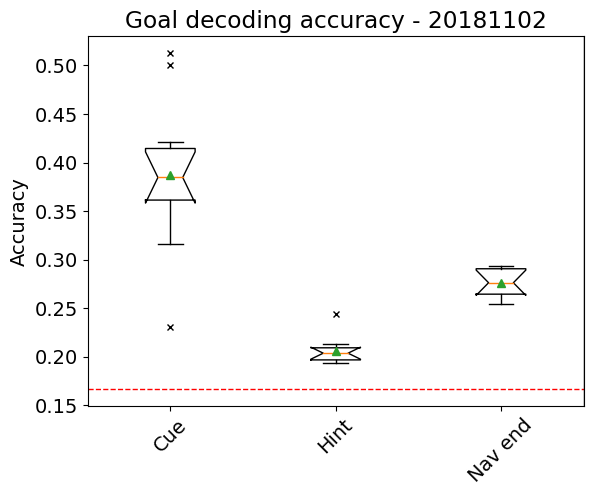

In [201]:
# Plot variance in prediciton accuracy between datasets
accuracies_goal = {'Cue': accuracy_goal_cue, 'Hint': accuracy_goal_hints, 'Nav end': accuracy_goal_navend}

plt.figure()
plt.title(f'Goal decoding accuracy - {day_dir}')
plt.boxplot(accuracies_goal.values(), showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
# plt.violinplot(accuracies.values(), showextrema=False)
plt.axhline(y=1/6, color='r', linewidth=1, linestyle='--')
plt.axvline(x=3.5, color='k', linewidth=1)
plt.xticks(np.arange(1, 4), labels=accuracies_goal.keys(), rotation=45)
plt.ylabel('Accuracy')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/goal_decoding_accuracy.png', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_95615/83588571.py:13: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


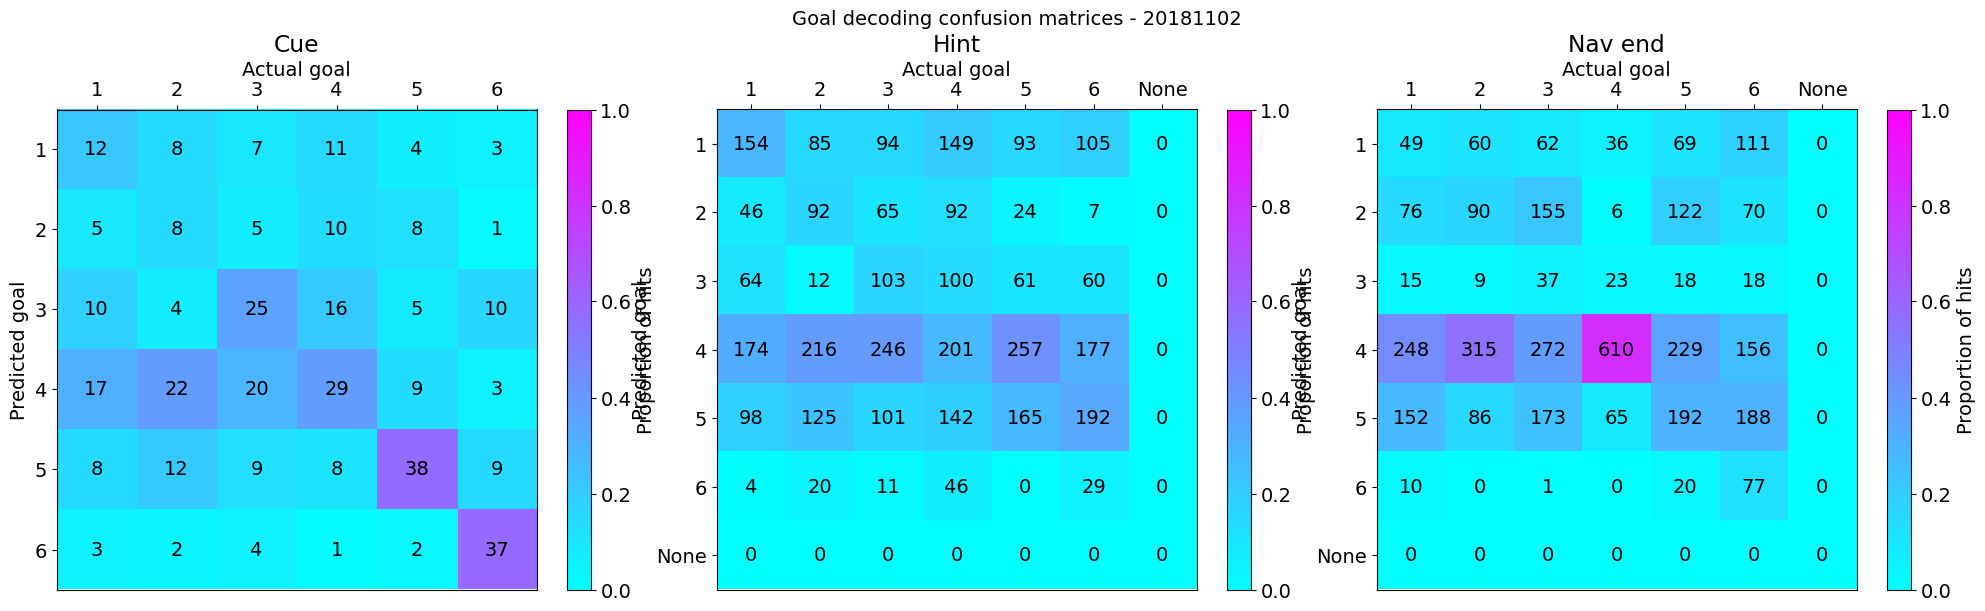

In [202]:
# Plot confusion matrices for cue, hint and nav end in a single plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Goal decoding confusion matrices - {day_dir}', fontsize=14, y=0.925)
confusion_matrices_goal = {'Cue': confusion_goal_cue, 'Hint': confusion_goal_hints, 'Nav end': confusion_goal_navend}

for i, entry in enumerate(confusion_matrices_goal.items()):
    label, conf_mat = entry
    num_cats = conf_mat.shape[0]
    col_sums = np.sum(conf_mat, axis=0)
    conf_mat_prop = np.empty_like(conf_mat)
    for col, val in enumerate(col_sums):
        conf_mat_prop[:,col] = conf_mat[:,col] / val
    conf_mat_prop = np.nan_to_num(conf_mat_prop)

    ax = axes[i]
    ax.set_title(label)
    im = ax.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Proportion of hits', shrink=0.75)

    class_labels = list(range(1, num_cats+1))
    if len(class_labels) > num_goals:
        class_labels.pop()
        class_labels.append('None')
    ax.set_xticks(np.arange(num_cats), labels=class_labels)
    ax.set_yticks(np.arange(num_cats), labels=class_labels)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xlabel('Actual goal')
    ax.set_ylabel('Predicted goal')
    ax.xaxis.set_label_position('top')

    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/goal_decoding_confusion.png', bbox_inches='tight')

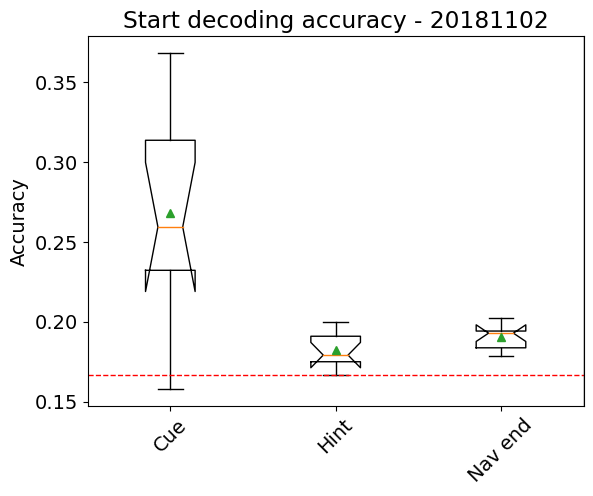

In [203]:
# Plot variance in prediciton accuracy between datasets
accuracies_start = {'Cue': accuracy_start_cue, 'Hint': accuracy_start_hints, 'Nav end': accuracy_start_navend}

plt.figure()
plt.title(f'Start decoding accuracy - {day_dir}')
plt.boxplot(accuracies_start.values(), showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
# plt.violinplot(accuracies.values(), showextrema=False)
plt.axhline(y=1/6, color='r', linewidth=1, linestyle='--')
plt.axvline(x=3.5, color='k', linewidth=1)
plt.xticks(np.arange(1, 4), labels=accuracies_start.keys(), rotation=45)
plt.ylabel('Accuracy')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/start_decoding_accuracy.png', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_95615/1153431351.py:13: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


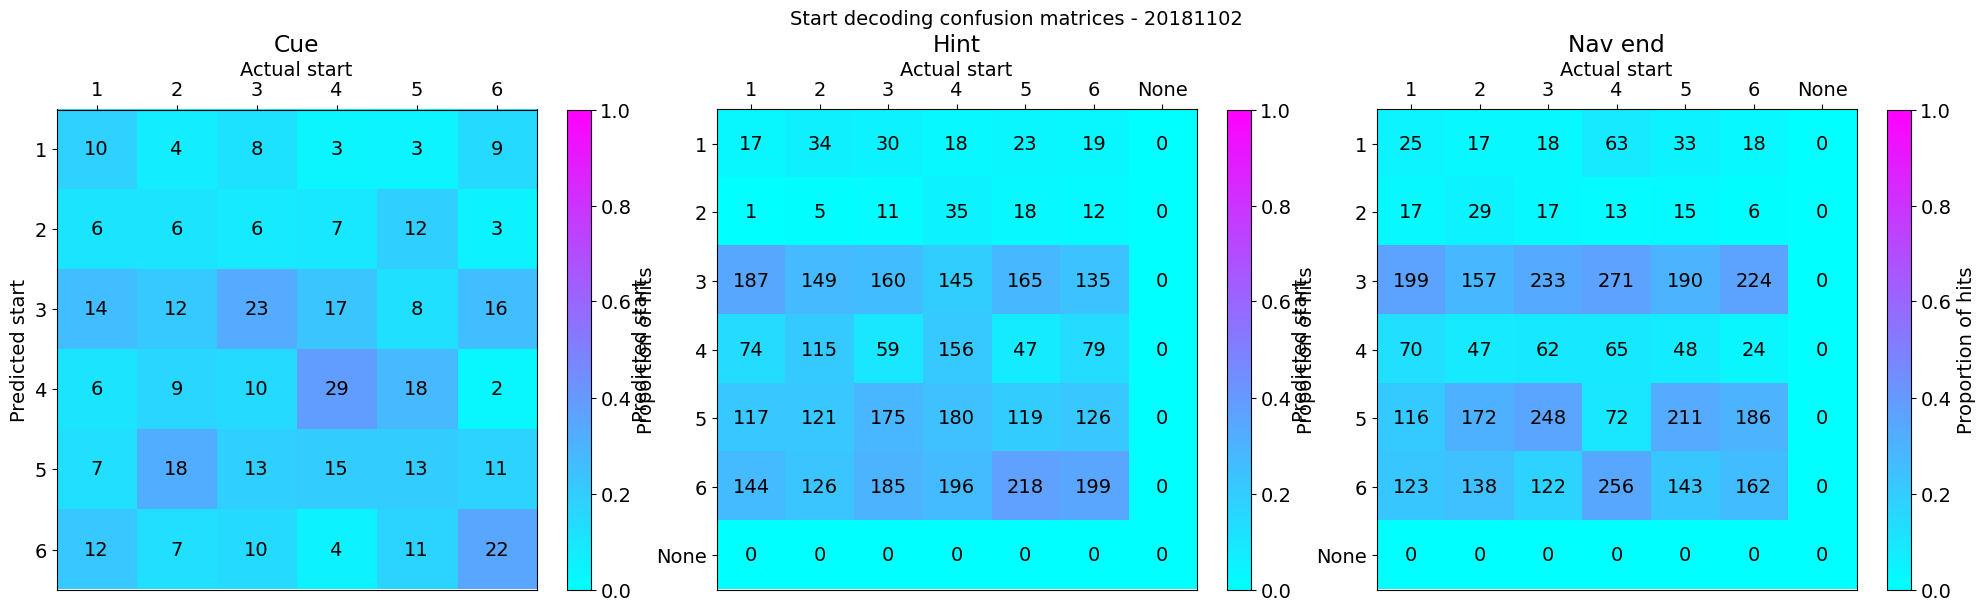

In [204]:
# Plot confusion matrices for cue, hint and nav end in a single plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Start decoding confusion matrices - {day_dir}', fontsize=14, y=0.925)
confusion_matrices_start = {'Cue': confusion_start_cue, 'Hint': confusion_start_hints, 'Nav end': confusion_start_navend}

for i, entry in enumerate(confusion_matrices_start.items()):
    label, conf_mat = entry
    num_cats = conf_mat.shape[0]
    col_sums = np.sum(conf_mat, axis=0)
    conf_mat_prop = np.empty_like(conf_mat)
    for col, val in enumerate(col_sums):
        conf_mat_prop[:,col] = conf_mat[:,col] / val
    conf_mat_prop = np.nan_to_num(conf_mat_prop)

    ax = axes[i]
    ax.set_title(label)
    im = ax.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Proportion of hits', shrink=0.75)

    class_labels = list(range(1, num_cats+1))
    if len(class_labels) > num_goals:
        class_labels.pop()
        class_labels.append('None')
    ax.set_xticks(np.arange(num_cats), labels=class_labels)
    ax.set_yticks(np.arange(num_cats), labels=class_labels)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xlabel('Actual start')
    ax.set_ylabel('Predicted start')
    ax.xaxis.set_label_position('top')

    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/start_decoding_confusion.png', bbox_inches='tight')

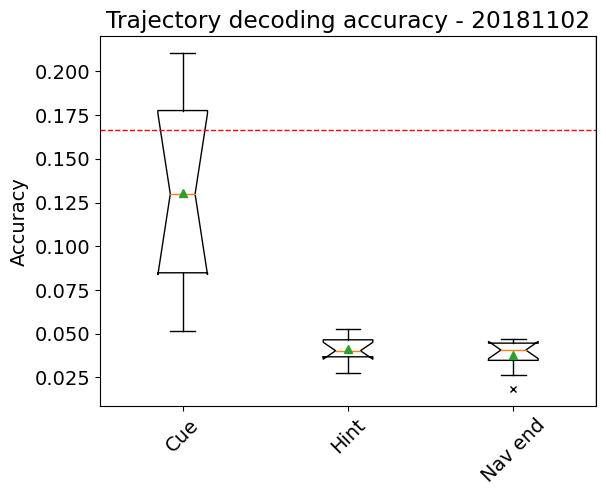

In [205]:
# Plot variance in prediciton accuracy between datasets
accuracies_traj = {'Cue': accuracy_traj_cue, 'Hint': accuracy_traj_hints, 'Nav end': accuracy_traj_navend}

plt.figure()
plt.title(f'Trajectory decoding accuracy - {day_dir}')
plt.boxplot(accuracies_traj.values(), showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
# plt.violinplot(accuracies.values(), showextrema=False)
plt.axhline(y=1/6, color='r', linewidth=1, linestyle='--')
plt.axvline(x=3.5, color='k', linewidth=1)
plt.xticks(np.arange(1, 4), labels=accuracies_traj.keys(), rotation=45)
plt.ylabel('Accuracy')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/traj_decoding_accuracy.png', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_95615/3133527284.py:13: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


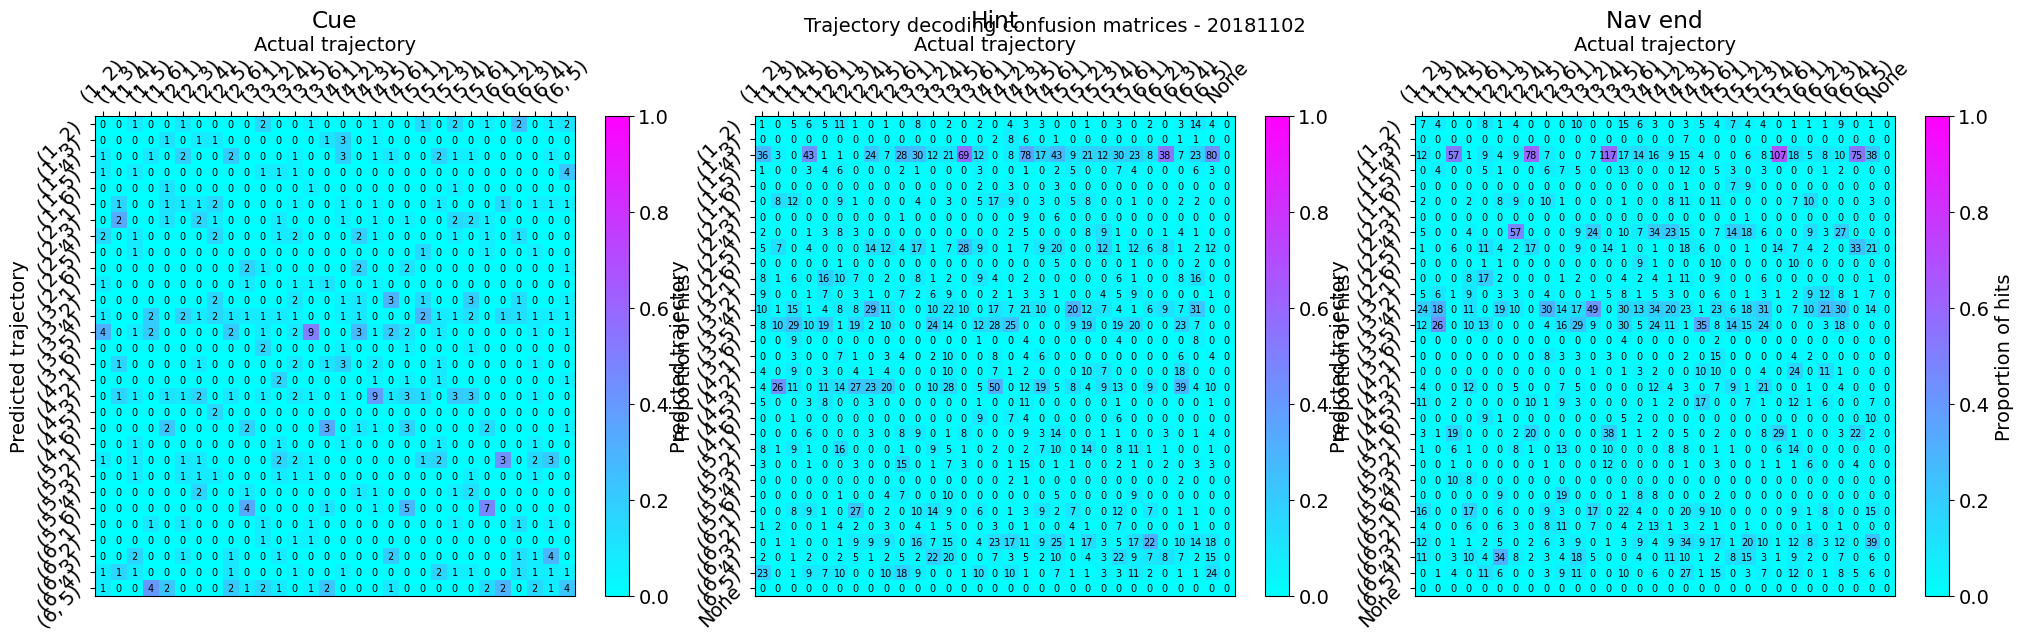

In [206]:
# Plot confusion matrices for cue, hint and nav end in a single plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Trajectory decoding confusion matrices - {day_dir}', fontsize=14, y=0.925)
confusion_matrices_traj = {'Cue': confusion_traj_cue, 'Hint': confusion_traj_hints, 'Nav end': confusion_traj_navend}

for i, entry in enumerate(confusion_matrices_traj.items()):
    label, conf_mat = entry
    num_cats = conf_mat.shape[0]
    col_sums = np.sum(conf_mat, axis=0)
    conf_mat_prop = np.empty_like(conf_mat)
    for col, val in enumerate(col_sums):
        conf_mat_prop[:,col] = conf_mat[:,col] / val
    conf_mat_prop = np.nan_to_num(conf_mat_prop)

    ax = axes[i]
    ax.set_title(label)
    im = ax.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Proportion of hits', shrink=0.75)

    ax.set_xticks(np.arange(num_cats), labels=class_to_traj(np.arange(1, num_cats+1)), rotation=45)
    ax.set_yticks(np.arange(num_cats), labels=class_to_traj(np.arange(1, num_cats+1)), rotation=45)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xlabel('Actual trajectory')
    ax.set_ylabel('Predicted trajectory')
    ax.xaxis.set_label_position('top')

    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k', fontsize=7)

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/traj_decoding_confusion.png', bbox_inches='tight')

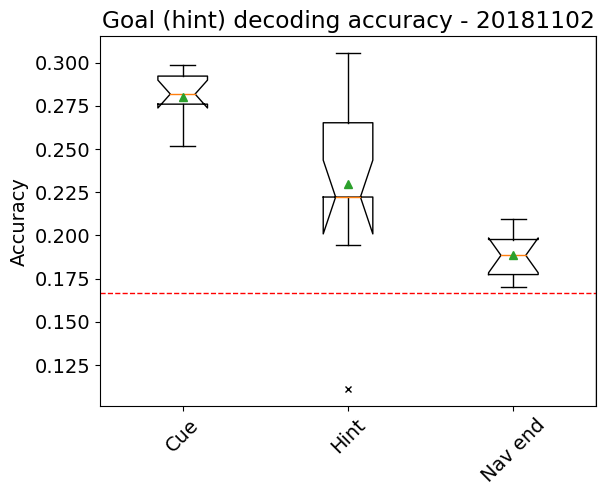

In [207]:
# Plot variance in prediciton accuracy between datasets
accuracies_hint = {'Cue': accuracy_hint_cue, 'Hint': accuracy_hint_hints, 'Nav end': accuracy_hint_navend}

plt.figure()
plt.title(f'Goal (hint) decoding accuracy - {day_dir}')
plt.boxplot(accuracies_hint.values(), showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
# plt.violinplot(accuracies.values(), showextrema=False)
plt.axhline(y=1/6, color='r', linewidth=1, linestyle='--')
plt.axvline(x=3.5, color='k', linewidth=1)
plt.xticks(np.arange(1, 4), labels=accuracies_hint.keys(), rotation=45)
plt.ylabel('Accuracy')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/hint_decoding_accuracy.png', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_95615/604960065.py:13: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


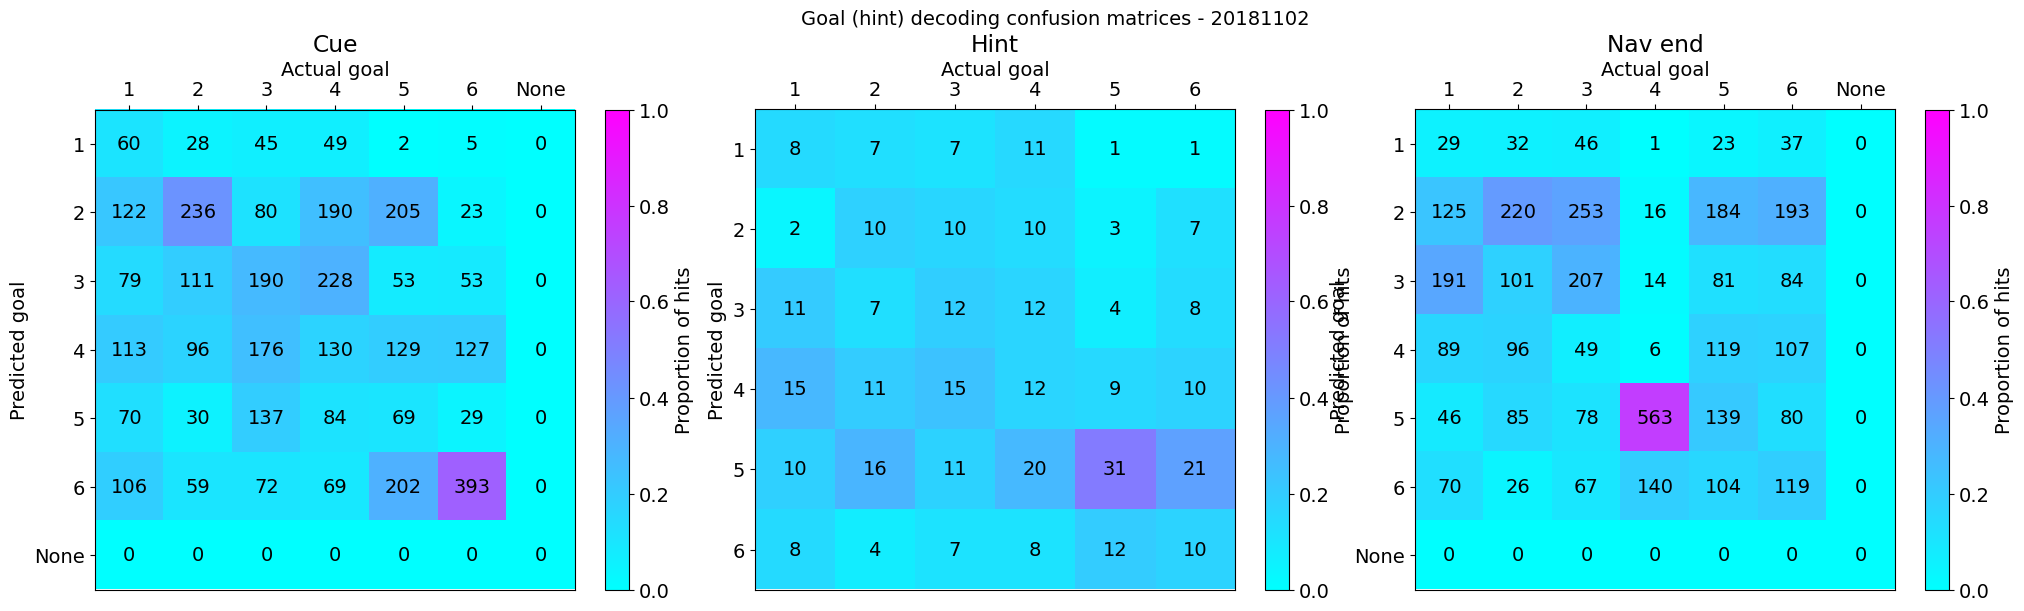

In [208]:
# Plot confusion matrices for cue, hint and nav end in a single plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Goal (hint) decoding confusion matrices - {day_dir}', fontsize=14, y=0.925)
confusion_matrices_hint = {'Cue': confusion_hint_cue, 'Hint': confusion_hint_hints, 'Nav end': confusion_hint_navend}

for i, entry in enumerate(confusion_matrices_hint.items()):
    label, conf_mat = entry
    num_cats = conf_mat.shape[0]
    col_sums = np.sum(conf_mat, axis=0)
    conf_mat_prop = np.empty_like(conf_mat)
    for col, val in enumerate(col_sums):
        conf_mat_prop[:,col] = conf_mat[:,col] / val
    conf_mat_prop = np.nan_to_num(conf_mat_prop)

    ax = axes[i]
    ax.set_title(label)
    im = ax.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Proportion of hits', shrink=0.75)

    class_labels = list(range(1, num_cats+1))
    if len(class_labels) > num_goals:
        class_labels.pop()
        class_labels.append('None')
    ax.set_xticks(np.arange(num_cats), labels=class_labels)
    ax.set_yticks(np.arange(num_cats), labels=class_labels)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xlabel('Actual goal')
    ax.set_ylabel('Predicted goal')
    ax.xaxis.set_label_position('top')

    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/hint_decoding_confusion.png', bbox_inches='tight')

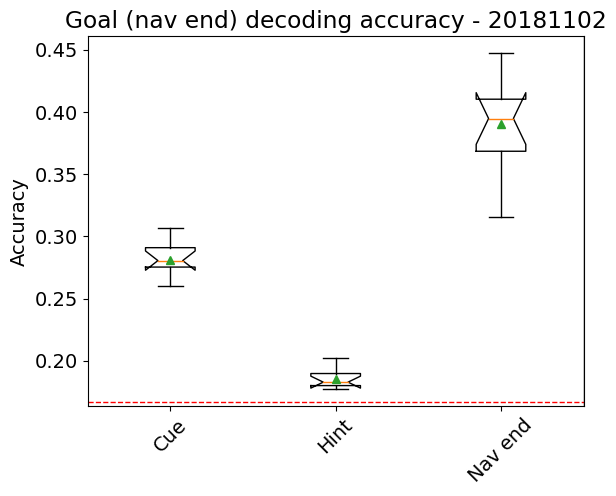

In [209]:
# Plot variance in prediciton accuracy between datasets
accuracies_poster = {'Cue': accuracy_poster_cue, 'Hint': accuracy_poster_hints, 'Nav end': accuracy_poster_navend}

plt.figure()
plt.title(f'Goal (nav end) decoding accuracy - {day_dir}')
plt.boxplot(accuracies_poster.values(), showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
# plt.violinplot(accuracies.values(), showextrema=False)
plt.axhline(y=1/6, color='r', linewidth=1, linestyle='--')
plt.axvline(x=3.5, color='k', linewidth=1)
plt.xticks(np.arange(1, 4), labels=accuracies_poster.keys(), rotation=45)
plt.ylabel('Accuracy')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/navend_decoding_accuracy.png', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_95615/424721849.py:13: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


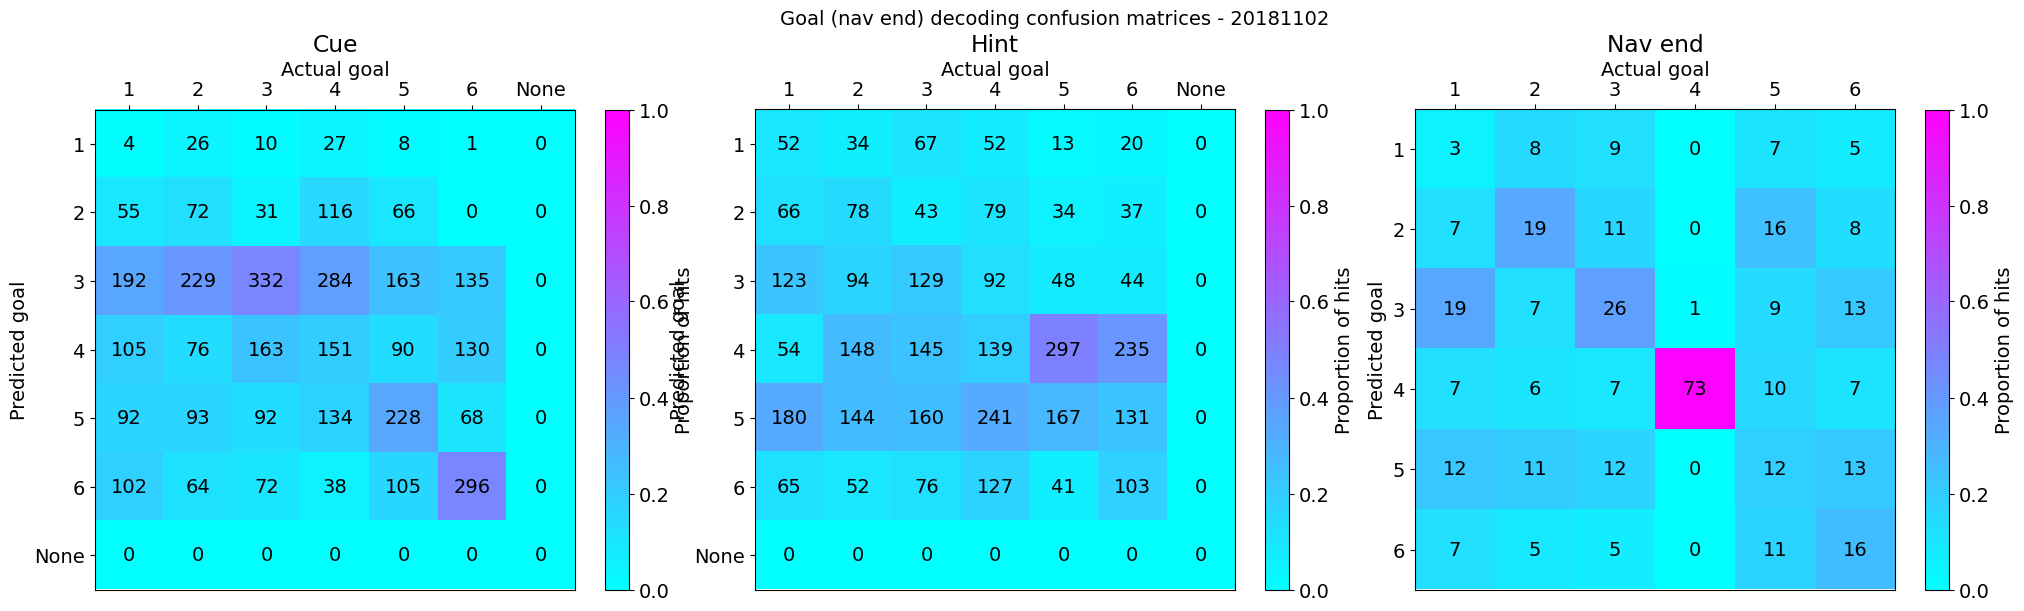

In [210]:
# Plot confusion matrices for cue, hint and nav end in a single plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Goal (nav end) decoding confusion matrices - {day_dir}', fontsize=14, y=0.925)
confusion_matrices_poster = {'Cue': confusion_poster_cue, 'Hint': confusion_poster_hints, 'Nav end': confusion_poster_navend}

for i, entry in enumerate(confusion_matrices_poster.items()):
    label, conf_mat = entry
    num_cats = conf_mat.shape[0]
    col_sums = np.sum(conf_mat, axis=0)
    conf_mat_prop = np.empty_like(conf_mat)
    for col, val in enumerate(col_sums):
        conf_mat_prop[:,col] = conf_mat[:,col] / val
    conf_mat_prop = np.nan_to_num(conf_mat_prop)

    ax = axes[i]
    ax.set_title(label)
    im = ax.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Proportion of hits', shrink=0.75)

    class_labels = list(range(1, num_cats+1))
    if len(class_labels) > num_goals:
        class_labels.pop()
        class_labels.append('None')
    ax.set_xticks(np.arange(num_cats), labels=class_labels)
    ax.set_yticks(np.arange(num_cats), labels=class_labels)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xlabel('Actual goal')
    ax.set_ylabel('Predicted goal')
    ax.xaxis.set_label_position('top')

    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/navend_decoding_confusion.png', bbox_inches='tight')

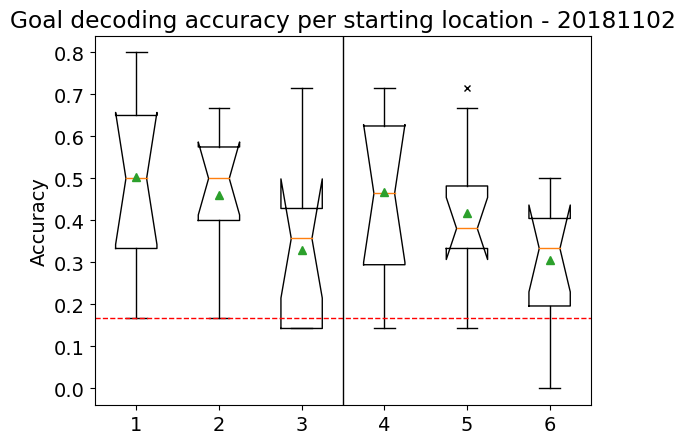

In [211]:
# Plot variance in prediciton accuracy between datasets
accuracies_goal_per_start = dict(zip(range(1, num_goals+1), accuracy_goal_per_start_cue))

plt.figure()
plt.title(f'Goal decoding accuracy per starting location - {day_dir}')
plt.boxplot(accuracies_goal_per_start.values(), showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
# plt.violinplot(accuracies.values(), showextrema=False)
plt.axhline(y=1/6, color='r', linewidth=1, linestyle='--')
plt.axvline(x=3.5, color='k', linewidth=1)
plt.xticks(np.arange(1, num_goals+1), labels=accuracies_goal_per_start.keys())
plt.ylabel('Accuracy')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/goalperstart_decoding_accuracy.png', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_95615/1741810303.py:13: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


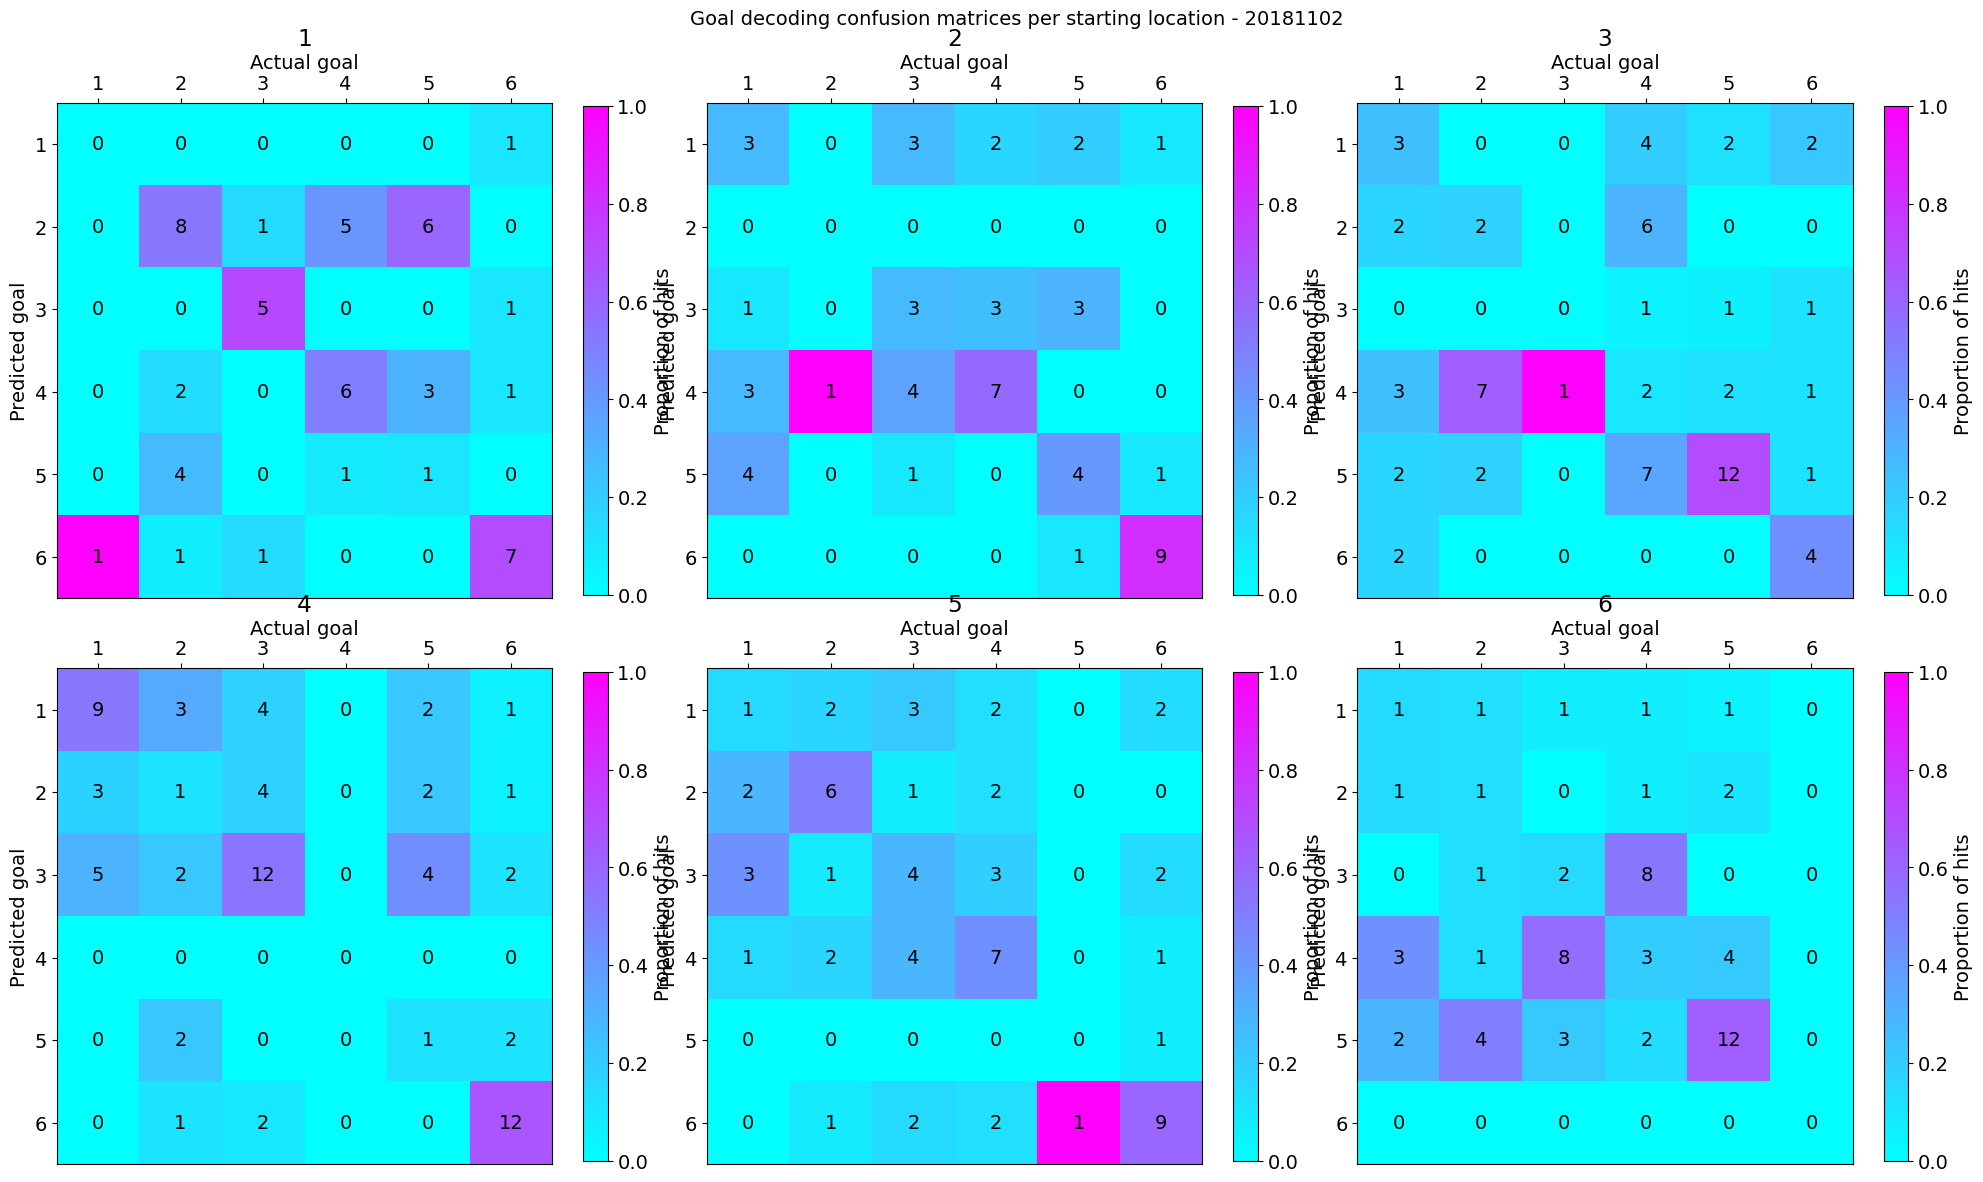

In [212]:
# Plot confusion matrices for cue, hint and nav end in a single plot
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0, wspace=0.05, hspace=0.1)
plt.suptitle(f'Goal decoding confusion matrices per starting location - {day_dir}', fontsize=14, y=0.97)
confusion_matrices_goal_per_start = dict(zip(range(1, num_goals+1), confusion_goal_per_start_cue))

for i, entry in enumerate(confusion_matrices_goal_per_start.items()):
    label, conf_mat = entry
    num_cats = conf_mat.shape[0]
    col_sums = np.sum(conf_mat, axis=0)
    conf_mat_prop = np.empty_like(conf_mat)
    for col, val in enumerate(col_sums):
        conf_mat_prop[:,col] = conf_mat[:,col] / val
    conf_mat_prop = np.nan_to_num(conf_mat_prop)

    ax = axes[i//3, i%3]
    ax.set_title(label)
    im = ax.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Proportion of hits', shrink=0.95)

    class_labels = list(range(1, num_cats+1))
    if len(class_labels) > num_goals:
        class_labels.pop()
        class_labels.append('None')
    ax.set_xticks(np.arange(num_cats), labels=class_labels)
    ax.set_yticks(np.arange(num_cats), labels=class_labels)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xlabel('Actual goal')
    ax.set_ylabel('Predicted goal')
    ax.xaxis.set_label_position('top')

    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/goalperstart_decoding_confusion.png', bbox_inches='tight')

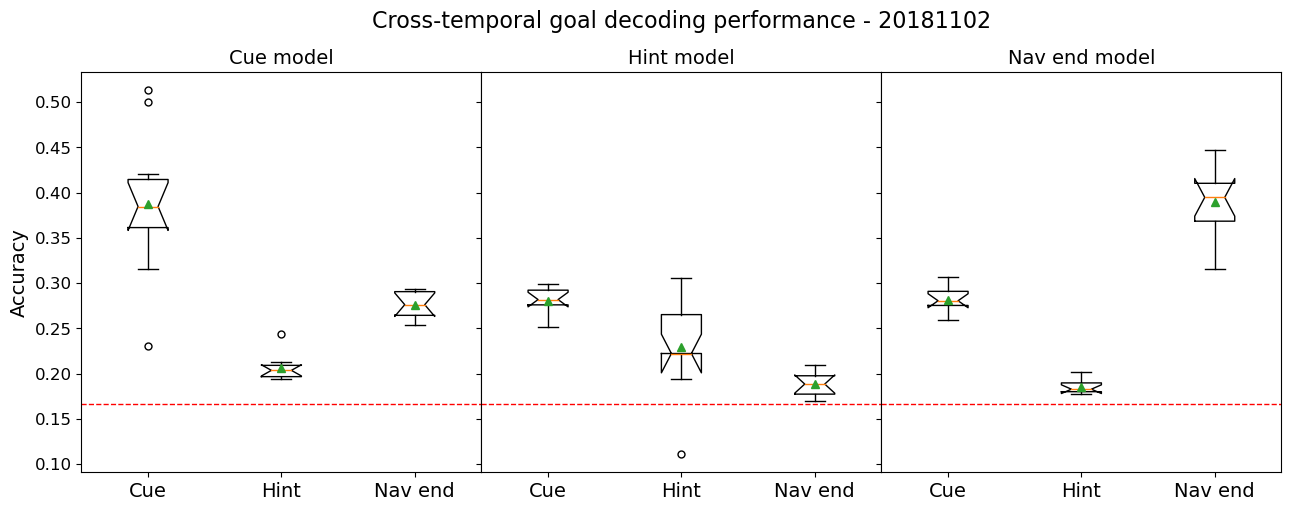

In [226]:
# Plot cross-temporal decoding accuracies for cue, hint and nav end models in a single plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
plt.rcParams['font.size'] = 12
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0, hspace=0.1)
plt.suptitle(f'Cross-temporal goal decoding performance - {day_dir}', fontsize=16, y=1.025)
model_names = ['Cue', 'Hint', 'Nav end']

for k, accuracies in enumerate([accuracies_goal, accuracies_hint, accuracies_poster]):
    axes[k].set_title(f'{model_names[k]} model', fontsize=14)
    axes[k].boxplot(accuracies.values(), showmeans=True, notch=True, flierprops={'marker': 'o', 'markersize': 5})
    axes[k].axhline(y=1/6, color='r', linewidth=1, linestyle='--')
    axes[k].set_xticks(np.arange(1, 4), labels=accuracies.keys(), fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=14)

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/crosstemp_decoding_accuracy.eps', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_95615/1106311609.py:15: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


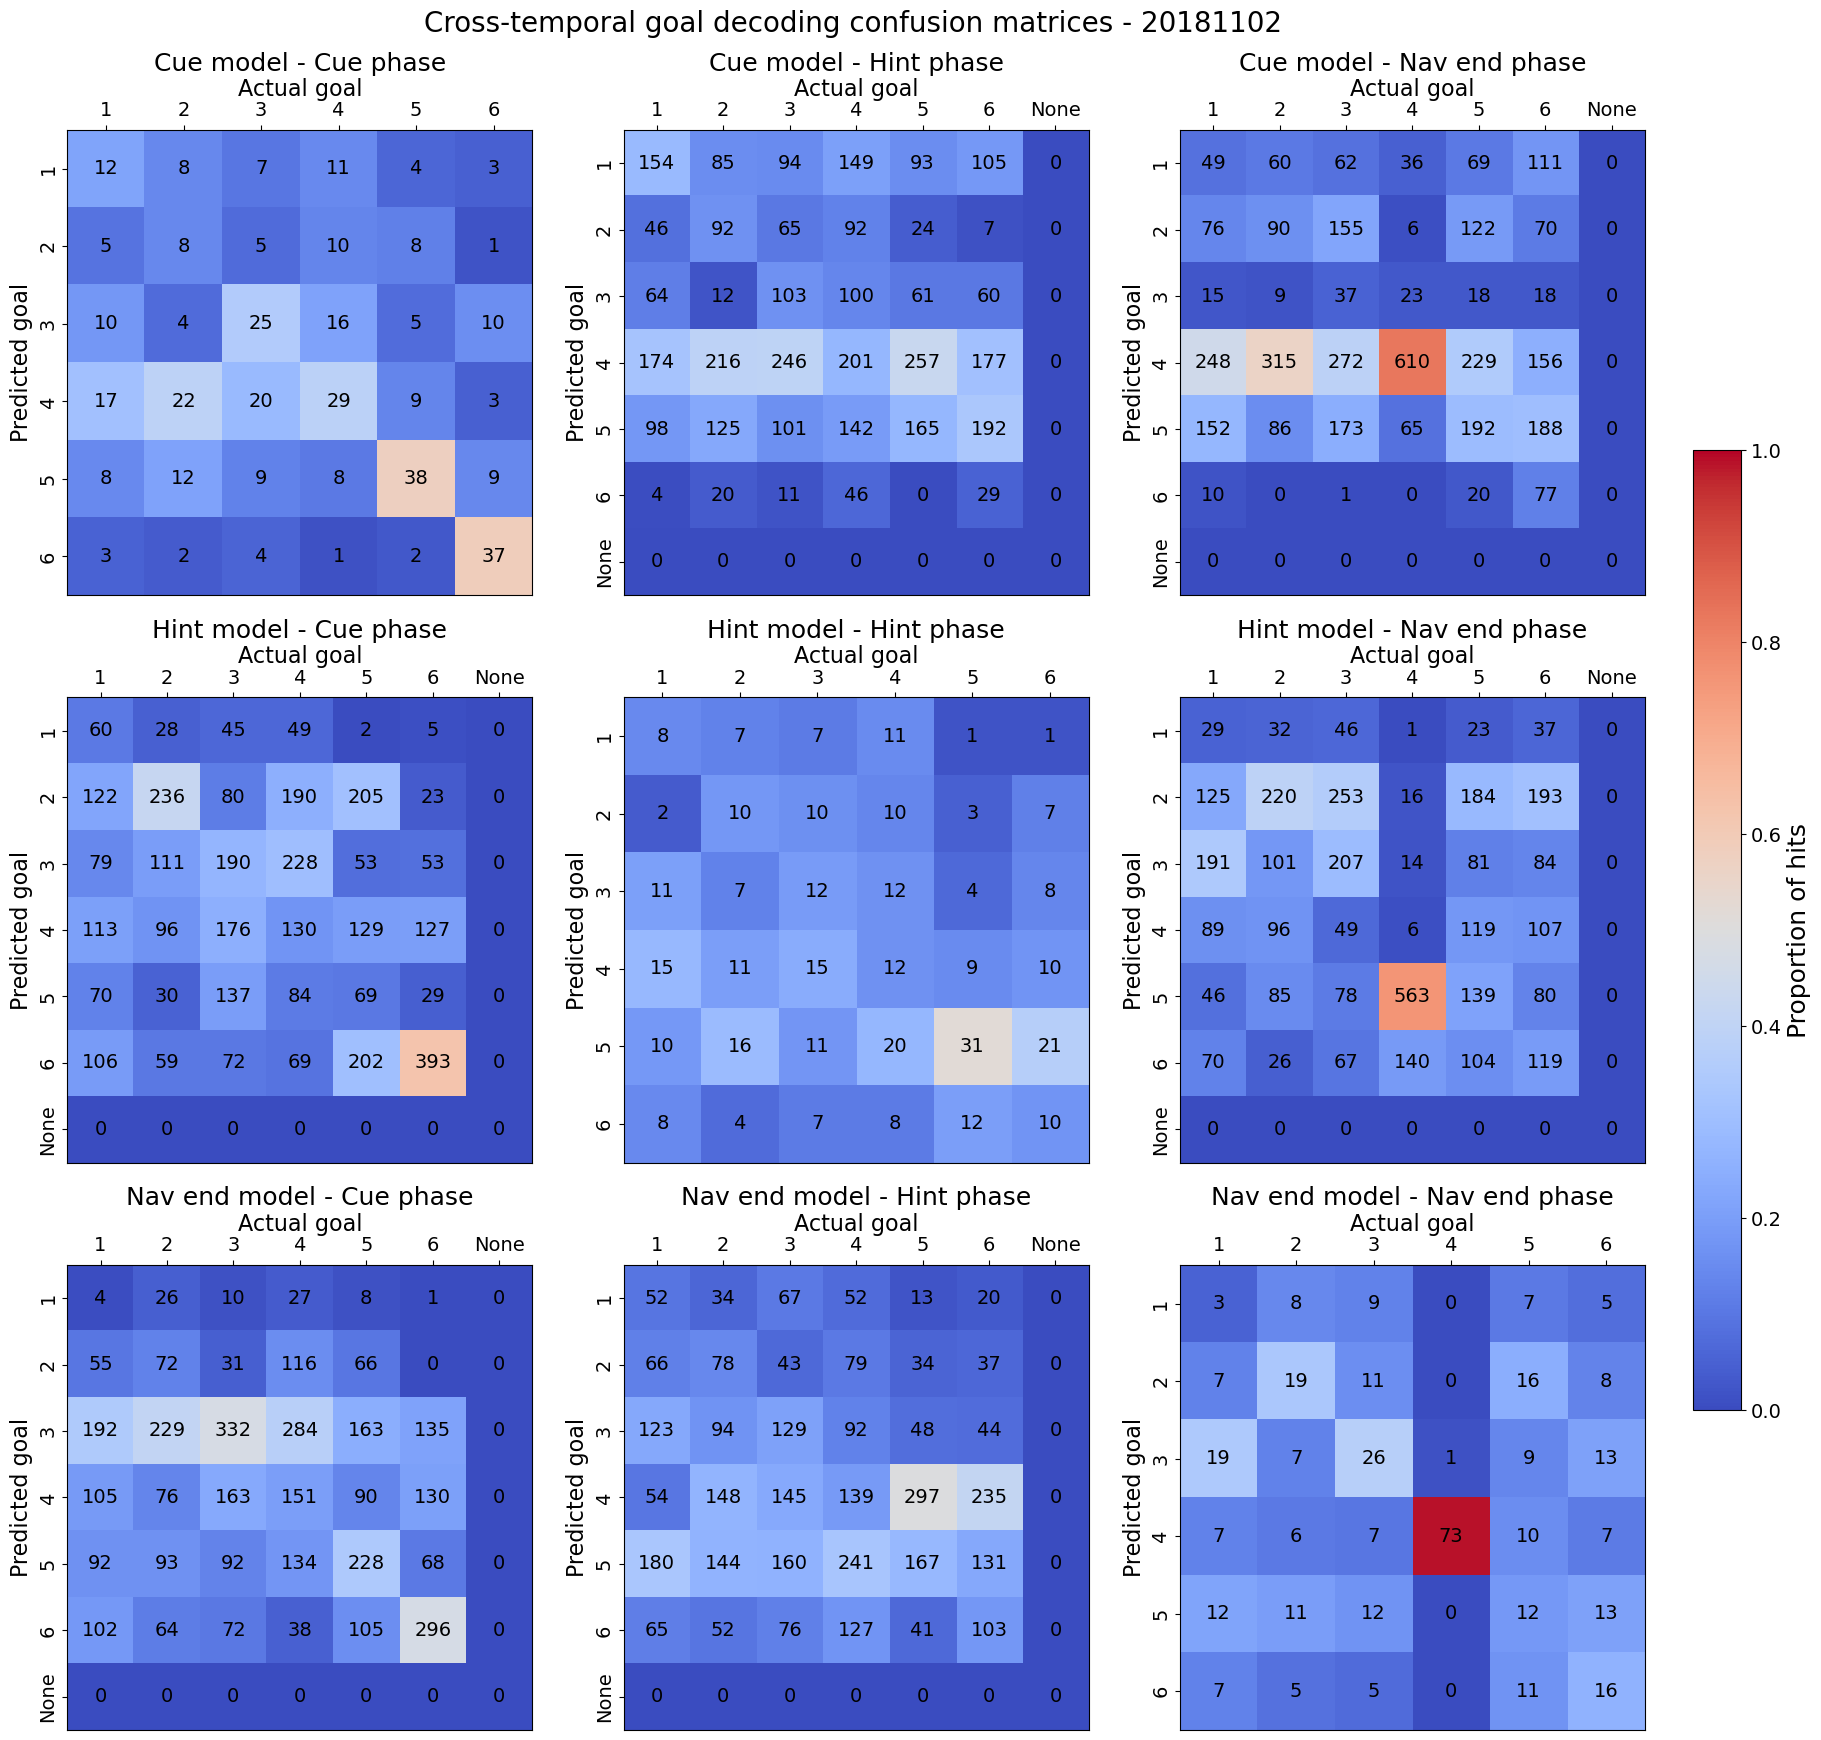

In [229]:
# Plot confusion matrices for all cross-temporal decoders in a single plot
fig, axes = plt.subplots(3, 3, figsize=(24, 20))
plt.rcParams['font.size'] = 14
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.18, hspace=0.22)
plt.suptitle(f'Cross-temporal goal decoding confusion matrices - {day_dir}', fontsize=20, y=0.96, x=0.43)
model_names = ['Cue', 'Hint', 'Nav end']

for k, confusion_matrices in enumerate([confusion_matrices_goal, confusion_matrices_hint, confusion_matrices_poster]):
    for i, entry in enumerate(confusion_matrices.items()):
        label, conf_mat = entry
        num_cats = conf_mat.shape[0]
        col_sums = np.sum(conf_mat, axis=0)
        conf_mat_prop = np.empty_like(conf_mat)
        for col, val in enumerate(col_sums):
            conf_mat_prop[:,col] = conf_mat[:,col] / val
        conf_mat_prop = np.nan_to_num(conf_mat_prop)

        ax = axes[k,i]
        ax.set_title(f'{model_names[k]} model - {label} phase', fontsize=18, y=1.11)
        im = ax.imshow(conf_mat_prop, cmap='coolwarm', vmin=0, vmax=1)

        class_labels = list(range(1, num_cats+1))
        if len(class_labels) > num_goals:
            class_labels.pop()
            class_labels.append('None')
        ax.set_xticks(np.arange(num_cats), labels=class_labels)
        ax.set_yticks(np.arange(num_cats), labels=class_labels, va='center', rotation=90)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        ax.set_xlabel('Actual goal', fontsize=16)
        ax.set_ylabel('Predicted goal', fontsize=16)
        ax.xaxis.set_label_position('top')

        for i, row in enumerate(conf_mat):
            for j, val in enumerate(row):
                ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')
cbar = plt.colorbar(im, ax=axes, pad=0.025, shrink=0.6)
cbar.set_label('Proportion of hits', size=18)

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/crosstemp_decoding_confusion.eps', bbox_inches='tight')

### Pseudopopulation analysis

In [235]:
def group_by_trajectory(timeseries: np.array, trajectories: np.array) -> list:
    # num_goals = 6
    grouped = {(i+1, j+1): list() for j in range(num_goals) for i in range(num_goals) if i != j}
    for idx, traj in enumerate(trajectories):
        goal1, goal2 = int(traj[0]), int(traj[1])
        if goal1 == 0:
            continue
        grouped[(goal1, goal2)].append(timeseries[idx])
    return grouped

In [237]:
# Load data from .pkl files
day_list = ['20181105', '20181102', '20181101']
num_sess = len(day_list)

all_spikerates_cue, all_spikerates_hints, all_spikerates_navend = list(), list(), list()
all_goals_cue, all_goals_hints, all_goals_navend = list(), list(), list()
all_trajectories_cue, all_trajectories_hints, all_trajectories_navend = list(), list(), list()

for day in day_list:
    with open(f'data/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        # Drop the first trial from each day's dataset
        all_spikerates_cue.append(data['raw_data']['spikerates_cue'][1:])
        all_spikerates_hints.append(data['raw_data']['spikerates_hints'][1:])
        all_spikerates_navend.append(data['raw_data']['spikerates_navend'][1:])

        all_goals_cue.append(data['raw_data']['goals_cue'][1:])
        all_goals_hints.append(data['raw_data']['goals_hints'][1:])
        all_goals_navend.append(data['raw_data']['goals_navend'][1:])

        all_trajectories_cue.append(data['raw_data']['trajectories_cue'][1:])
        all_trajectories_hints.append(data['raw_data']['trajectories_hints'][1:])
        all_trajectories_navend.append(data['raw_data']['trajectories_navend'][1:])

In [259]:
# Append cells from each session to form a pseudopopulation, append in chronological order on responses grouped by (start, end) goals
# Cue phase spike rates
all_spikerates_cue_per_traj = list()
for i in range(num_sess):
    all_spikerates_cue_per_traj.append(group_by_trajectory(all_spikerates_cue[i], all_trajectories_cue[i]))
trajectories = list(all_spikerates_cue_per_traj[0].keys())
combined_spikerates_cue_per_traj = {key: list() for key in trajectories}
for traj in trajectories:
    trials_data = [sess[traj] for sess in all_spikerates_cue_per_traj]
    num_trials = min(map(len, trials_data))
    for trial in range(num_trials):
        combined_spikerates_cue_per_traj[traj].append(np.hstack([sess[trial] for sess in trials_data]))
    combined_spikerates_cue_per_traj[traj] = np.vstack(combined_spikerates_cue_per_traj[traj])

# Hint view spike rates
all_spikerates_hints_per_traj = list()
for i in range(num_sess):
    all_spikerates_hints_per_traj.append(group_by_trajectory(all_spikerates_hints[i], all_trajectories_hints[i]))
combined_spikerates_hints_per_traj = {key: list() for key in trajectories}
for traj in trajectories:
    trials_data = [sess[traj] for sess in all_spikerates_hints_per_traj]
    num_trials = min(map(len, trials_data))
    for trial in range(num_trials):
        combined_spikerates_hints_per_traj[traj].append(np.hstack([sess[trial] for sess in trials_data]))
    combined_spikerates_hints_per_traj[traj] = np.vstack(combined_spikerates_hints_per_traj[traj])

# Nav end phase spike rates
all_spikerates_navend_per_traj = list()
for i in range(num_sess):
    all_spikerates_navend_per_traj.append(group_by_trajectory(all_spikerates_navend[i], all_trajectories_navend[i]))
combined_spikerates_navend_per_traj = {key: list() for key in trajectories}
for traj in trajectories:
    trials_data = [sess[traj] for sess in all_spikerates_navend_per_traj]
    num_trials = min(map(len, trials_data))
    for trial in range(num_trials):
        combined_spikerates_navend_per_traj[traj].append(np.hstack([sess[trial] for sess in trials_data]))
    combined_spikerates_navend_per_traj[traj] = np.vstack(combined_spikerates_navend_per_traj[traj])

# Collect spike rate data into single arrays for each phase
combined_spikerates_cue, combined_goals_cue = list(), list()
for traj, obs in combined_spikerates_cue_per_traj.items():
    combined_spikerates_cue.append(obs)
    combined_goals_cue.extend(obs.shape[0]*[traj[1]])
combined_spikerates_cue = np.vstack(combined_spikerates_cue)
combined_goals_cue = np.array(combined_goals_cue)

combined_spikerates_hints, combined_goals_hints = list(), list()
for traj, obs in combined_spikerates_hints_per_traj.items():
    combined_spikerates_hints.append(obs)
    combined_goals_hints.extend(obs.shape[0]*[traj[1]])
combined_spikerates_hints = np.vstack(combined_spikerates_hints)
combined_goals_hints = np.array(combined_goals_hints)

combined_spikerates_navend, combined_goals_navend = list(), list()
for traj, obs in combined_spikerates_navend_per_traj.items():
    combined_spikerates_navend.append(obs)
    combined_goals_navend.extend(obs.shape[0]*[traj[1]])
combined_spikerates_navend = np.vstack(combined_spikerates_navend)
combined_goals_navend = np.array(combined_goals_navend)

# Shuffle the order of the observations
shuffle_order = np.random.permutation(combined_goals_cue.shape[0])
combined_spikerates_cue = combined_spikerates_cue[shuffle_order]
combined_goals_cue = combined_goals_cue[shuffle_order]

shuffle_order = np.random.permutation(combined_goals_hints.shape[0])
combined_spikerates_hints = combined_spikerates_hints[shuffle_order]
combined_goals_hints = combined_goals_hints[shuffle_order]

shuffle_order = np.random.permutation(combined_goals_navend.shape[0])
combined_spikerates_navend = combined_spikerates_navend[shuffle_order]
combined_goals_navend = combined_goals_navend[shuffle_order]

Cross-temporal pseudopopulation decoding, trained on cue phase

In [260]:
# Build decoder for 6+1 classes
k_fold = 10
ppop_probmins_goal = np.zeros(k_fold)
ppop_accuracy_goal_cue = np.zeros(k_fold)
ppop_confusion_goal_cue = np.zeros((num_goals, num_goals))
ppop_models_goal = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(combined_spikerates_cue, combined_goals_cue, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    ppop_probmins_goal[i] = np.min(y_pred_proba)
    ppop_accuracy_goal_cue[i] = prediction_accuracy(y_pred, y_test)
    ppop_confusion_goal_cue += confusion_matrix(y_pred, y_test, num_goals)
    ppop_models_goal.append(lda)

# Fit models using each fold of data
ppop_confusion_goal_hints, ppop_confusion_goal_navend = np.zeros((num_goals+1, num_goals+1)), np.zeros((num_goals+1, num_goals+1))
ppop_accuracy_goal_hints, ppop_accuracy_goal_navend = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(ppop_models_goal):
    ppop_models_goal[i] = ResponseClassifier(model)
    ppop_models_goal[i].set_thresh(ppop_probmins_goal[i])

    # Prediction on hint views
    hints_preds = model.predict(combined_spikerates_hints)
    ppop_confusion_goal_hints += confusion_matrix(hints_preds, combined_goals_hints, num_goals+1)
    ppop_accuracy_goal_hints[i] = prediction_accuracy(hints_preds, combined_goals_hints)

    # Prediction on navend phases
    navend_preds = model.predict(combined_spikerates_navend)
    ppop_confusion_goal_navend += confusion_matrix(navend_preds, combined_goals_navend, num_goals+1)
    ppop_accuracy_goal_navend[i] = prediction_accuracy(navend_preds, combined_goals_navend)

Cross-temporal pseudopopulation decoding, trained on hint views

In [261]:
# Build decoder for 6+1 classes
k_fold = 10
ppop_probmins_hint = np.zeros(k_fold)
ppop_accuracy_hint_hints = np.zeros(k_fold)
ppop_confusion_hint_hints = np.zeros((num_goals, num_goals))
ppop_models_hint = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(combined_spikerates_hints, combined_goals_hints, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    ppop_probmins_hint[i] = np.min(y_pred_proba)
    ppop_accuracy_hint_hints[i] = prediction_accuracy(y_pred, y_test)
    ppop_confusion_hint_hints += confusion_matrix(y_pred, y_test, num_goals)
    ppop_models_hint.append(lda)

# Fit models using each fold of data
ppop_confusion_hint_cue, ppop_confusion_hint_navend = np.zeros((num_goals+1, num_goals+1)), np.zeros((num_goals+1, num_goals+1))
ppop_accuracy_hint_cue, ppop_accuracy_hint_navend = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(ppop_models_hint):
    ppop_models_hint[i] = ResponseClassifier(model)
    ppop_models_hint[i].set_thresh(ppop_probmins_hint[i])

    # Prediction on cue phases
    cue_preds = model.predict(combined_spikerates_cue)
    ppop_confusion_hint_cue += confusion_matrix(cue_preds, combined_goals_cue, num_goals+1)
    ppop_accuracy_hint_cue[i] = prediction_accuracy(cue_preds, combined_goals_cue)

    # Prediction on navend phases
    navend_preds = model.predict(combined_spikerates_navend)
    ppop_confusion_hint_navend += confusion_matrix(navend_preds, combined_goals_navend, num_goals+1)
    ppop_accuracy_hint_navend[i] = prediction_accuracy(navend_preds, combined_goals_navend)

Cross-temporal pseudopopulation decoding, trained on navend posters

In [262]:
# Build decoder for 6+1 classes
k_fold = 10
ppop_probmins_poster = np.zeros(k_fold)
ppop_accuracy_poster_navend = np.zeros(k_fold)
ppop_confusion_poster_navend = np.zeros((num_goals, num_goals))
ppop_models_poster = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(combined_spikerates_navend, combined_goals_navend, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    ppop_probmins_poster[i] = np.min(y_pred_proba)
    ppop_accuracy_poster_navend[i] = prediction_accuracy(y_pred, y_test)
    ppop_confusion_poster_navend += confusion_matrix(y_pred, y_test, num_goals)
    ppop_models_poster.append(lda)

# Fit models using each fold of data
ppop_confusion_poster_cue, ppop_confusion_poster_hints = np.zeros((num_goals+1, num_goals+1)), np.zeros((num_goals+1, num_goals+1))
ppop_accuracy_poster_cue, ppop_accuracy_poster_hints = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(ppop_models_poster):
    ppop_models_poster[i] = ResponseClassifier(model)
    ppop_models_poster[i].set_thresh(ppop_probmins_poster[i])

    # Prediction on cue phases
    cue_preds = model.predict(combined_spikerates_cue)
    ppop_confusion_poster_cue += confusion_matrix(cue_preds, combined_goals_cue, num_goals+1)
    ppop_accuracy_poster_cue[i] = prediction_accuracy(cue_preds, combined_goals_cue)

    # Prediction on hitn views
    hints_preds = model.predict(combined_spikerates_hints)
    ppop_confusion_poster_hints += confusion_matrix(hints_preds, combined_goals_hints, num_goals+1)
    ppop_accuracy_poster_hints[i] = prediction_accuracy(hints_preds, combined_goals_hints)

Statistical tests between decoding performances

In [267]:
fstat_ppop_goal, pval_ppop_goal = f_oneway(ppop_accuracy_goal_cue, ppop_accuracy_goal_hints, ppop_accuracy_goal_navend)
tukey_ppop_goal = pairwise_tukeyhsd(np.concatenate([ppop_accuracy_goal_cue, ppop_accuracy_goal_hints, ppop_accuracy_goal_navend]), k_fold*['Cue'] + k_fold*['Hint'] + k_fold*['Nav_end'])

fstat_ppop_hint, pval_ppop_hint = f_oneway(ppop_accuracy_hint_cue, ppop_accuracy_hint_hints, ppop_accuracy_hint_navend)
tukey_ppop_hint = pairwise_tukeyhsd(np.concatenate([ppop_accuracy_hint_cue, ppop_accuracy_hint_hints, ppop_accuracy_hint_navend]), k_fold*['Cue'] + k_fold*['Hint'] + k_fold*['Nav_end'])

fstat_ppop_poster, pval_ppop_poster = f_oneway(ppop_accuracy_poster_cue, ppop_accuracy_poster_hints, ppop_accuracy_poster_navend)
tukey_ppop_poster = pairwise_tukeyhsd(np.concatenate([ppop_accuracy_poster_cue, ppop_accuracy_poster_hints, ppop_accuracy_poster_navend]), k_fold*['Cue'] + k_fold*['Hint'] + k_fold*['Nav_end'])

In [268]:
ppop_goal_stats = '\n'.join(['--- ANOVA results for Cue model ---', f'f-statistic: {fstat_ppop_goal}', f'p-value: {pval_ppop_goal}\n', str(tukey_ppop_goal)])
print(ppop_goal_stats)

--- ANOVA results for Cue model ---
f-statistic: 61.4017420585145
p-value: 8.992179623162927e-11

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
   Cue    Hint  -0.2192    0.0 -0.2697 -0.1686   True
   Cue Nav_end  -0.1576    0.0 -0.2082  -0.107   True
  Hint Nav_end   0.0615 0.0147   0.011  0.1121   True
-----------------------------------------------------


In [269]:
ppop_hint_stats = '\n'.join(['--- ANOVA results for Hint model ---', f'f-statistic: {fstat_ppop_hint}', f'p-value: {pval_ppop_hint}\n', str(tukey_ppop_hint)])
print(ppop_hint_stats)

--- ANOVA results for Hint model ---
f-statistic: 9.26847254224487
p-value: 0.0008619821546465803

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
   Cue    Hint  -0.0466 0.0895 -0.0992  0.0059  False
   Cue Nav_end  -0.0913 0.0006 -0.1438 -0.0387   True
  Hint Nav_end  -0.0446 0.1074 -0.0972  0.0079  False
-----------------------------------------------------


In [270]:
ppop_poster_stats = '\n'.join(['--- ANOVA results for Nav_end model ---', f'f-statistic: {fstat_ppop_poster}', f'p-value: {pval_ppop_poster}\n', str(tukey_ppop_poster)])
print(ppop_poster_stats)

--- ANOVA results for Nav_end model ---
f-statistic: 140.57307541421636
p-value: 5.3112253618435626e-15

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
   Cue    Hint  -0.1133   0.0 -0.1552 -0.0715   True
   Cue Nav_end   0.1677   0.0  0.1259  0.2096   True
  Hint Nav_end   0.2811   0.0  0.2392  0.3229   True
----------------------------------------------------


Pseudopopulation decoding plots

In [263]:
# Package variables
ppop_accuracies_goal = {'Cue': ppop_accuracy_goal_cue, 'Hint': ppop_accuracy_goal_hints, 'Nav end': ppop_accuracy_goal_navend}
ppop_accuracies_hint = {'Cue': ppop_accuracy_hint_cue, 'Hint': ppop_accuracy_hint_hints, 'Nav end': ppop_accuracy_hint_navend}
ppop_accuracies_poster = {'Cue': ppop_accuracy_poster_cue, 'Hint': ppop_accuracy_poster_hints, 'Nav end': ppop_accuracy_poster_navend}

ppop_confusion_matrices_goal = {'Cue': ppop_confusion_goal_cue, 'Hint': ppop_confusion_goal_hints, 'Nav end': ppop_confusion_goal_navend}
ppop_confusion_matrices_hint = {'Cue': ppop_confusion_hint_cue, 'Hint': ppop_confusion_hint_hints, 'Nav end': ppop_confusion_hint_navend}
ppop_confusion_matrices_poster = {'Cue': ppop_confusion_poster_cue, 'Hint': ppop_confusion_poster_hints, 'Nav end': ppop_confusion_poster_navend}

figsave_dir_2 = 'figures'

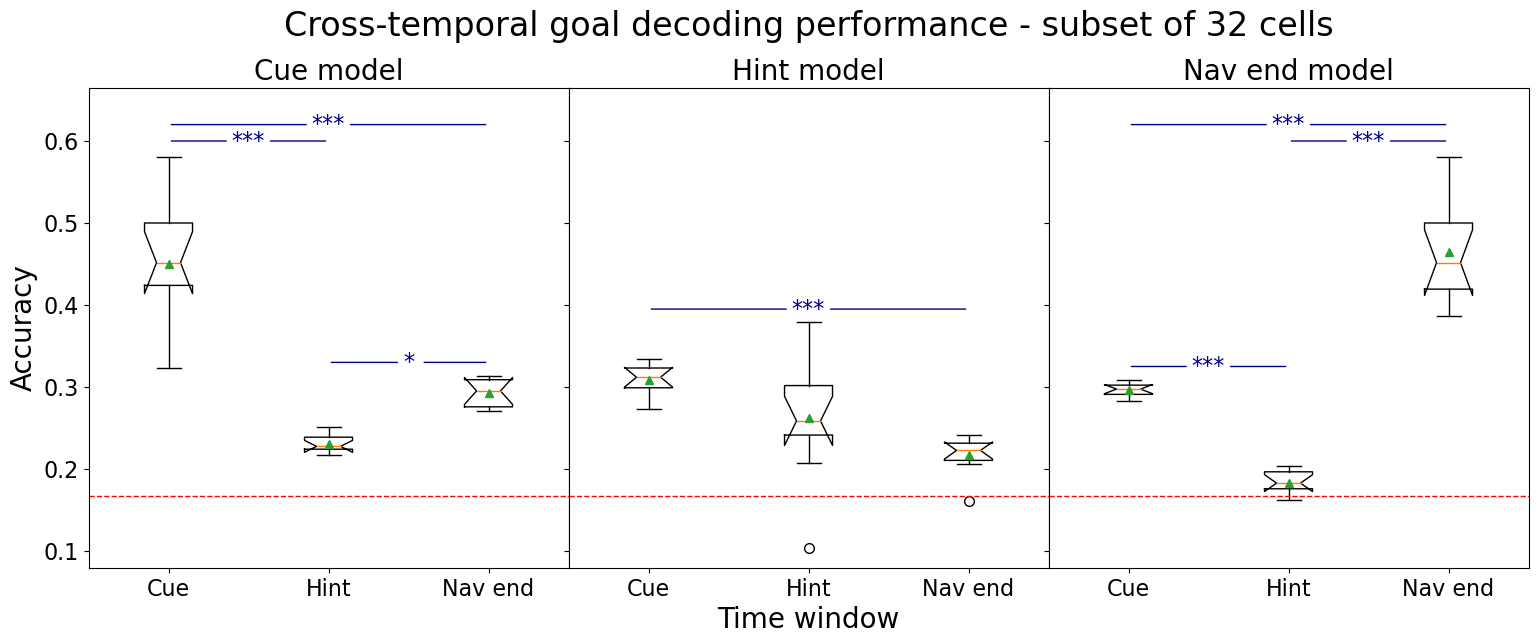

In [372]:
# Plot cross-temporal decoding accuracies for cue, hint and nav end models in a single plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
plt.rcParams['font.size'] = 16
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0, hspace=0.1)
plt.suptitle(f'Cross-temporal goal decoding performance - subset of 32 cells', fontsize=24, y=1.03)
model_names = ['Cue', 'Hint', 'Nav end']

for k, accuracies in enumerate([ppop_accuracies_goal, ppop_accuracies_hint, ppop_accuracies_poster]):
    axes[k].set_title(f'{model_names[k]} model', fontsize=20)
    axes[k].boxplot(accuracies.values(), showmeans=True, notch=True, flierprops={'marker': 'o', 'markersize': 7})
    # axes[k].violinplot(accuracies.values(), showextrema=False)
    axes[k].axhline(y=1/6, color='r', linewidth=1, linestyle='--')
    axes[k].set_xticks(np.arange(1, 4), labels=accuracies.keys())
axes[0].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Time window', fontsize=20)
axes[0].set_ylim([axes[0].get_ylim()[0], 1.1*axes[0].get_ylim()[1]])

# Manually add annotations for significant differences between groups
anno_colour = '#00008b'
arrowprops = {'arrowstyle': '-', 'lw': 1, 'color': anno_colour}

axes[0].annotate('***', xy=(1, 0.62), xytext=(2, 0.62), arrowprops=arrowprops, ha='center', va='center', color=anno_colour)
axes[0].annotate('', xy=(3, 0.62), xytext=(2.12, 0.62), arrowprops=arrowprops)
axes[0].annotate('***', xy=(1, 0.60), xytext=(1.5, 0.60), arrowprops=arrowprops, ha='center', va='center', color=anno_colour)
axes[0].annotate('', xy=(2, 0.60), xytext=(1.62, 0.60), arrowprops=arrowprops)
axes[0].annotate('*', xy=(2, 0.33), xytext=(2.5, 0.33), arrowprops=arrowprops, ha='center', va='center', color=anno_colour)
axes[0].annotate('', xy=(3, 0.33), xytext=(2.58, 0.33), arrowprops=arrowprops)

axes[1].annotate('***', xy=(1, 0.395), xytext=(2, 0.395), arrowprops=arrowprops, ha='center', va='center', color=anno_colour)
axes[1].annotate('', xy=(3, 0.395), xytext=(2.12, 0.395), arrowprops=arrowprops)

axes[2].annotate('***', xy=(1, 0.62), xytext=(2, 0.62), arrowprops=arrowprops, ha='center', va='center', color=anno_colour)
axes[2].annotate('', xy=(3, 0.62), xytext=(2.12, 0.62), arrowprops=arrowprops)
axes[2].annotate('***', xy=(2, 0.60), xytext=(2.5, 0.60), arrowprops=arrowprops, ha='center', va='center', color=anno_colour)
axes[2].annotate('', xy=(3, 0.60), xytext=(2.62, 0.60), arrowprops=arrowprops)
axes[2].annotate('***', xy=(1, 0.325), xytext=(1.5, 0.325), arrowprops=arrowprops, ha='center', va='center', color=anno_colour)
axes[2].annotate('', xy=(2, 0.325), xytext=(1.62, 0.325), arrowprops=arrowprops)


if not os.path.exists(figsave_dir_2):
    os.makedirs(figsave_dir_2)
plt.savefig(f'{figsave_dir_2}/decodeacc_Nov2018.eps', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_95615/3945198.py:15: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


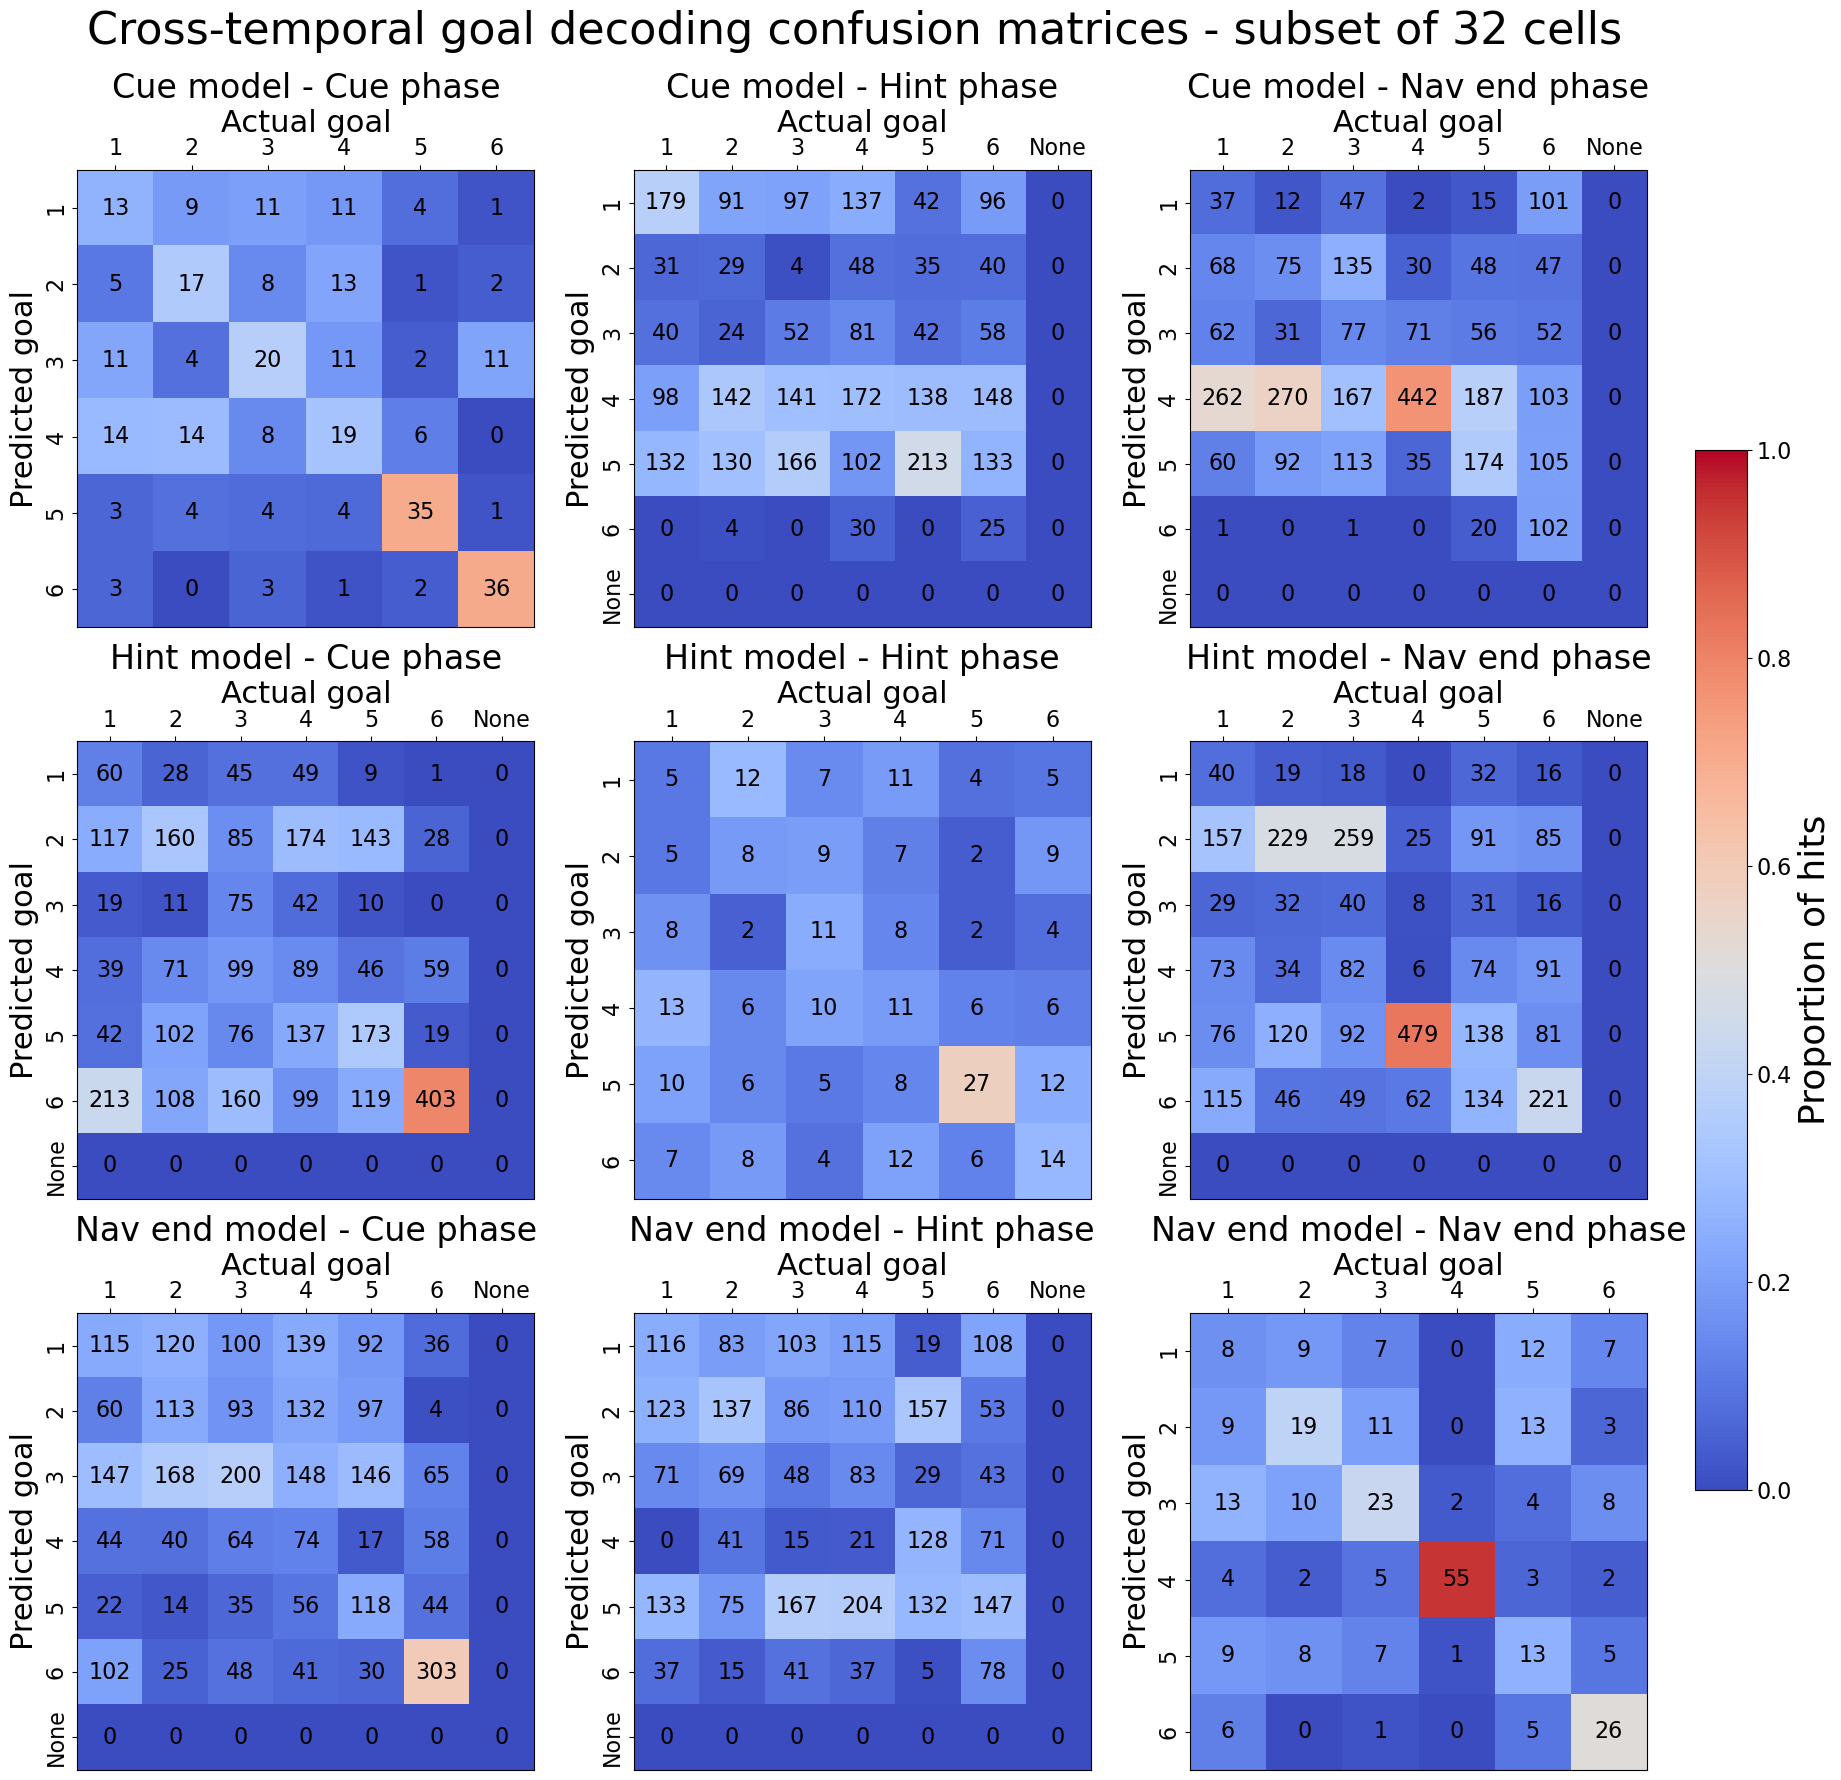

In [373]:
# Plot confusion matrices for all cross-temporal decoders in a single plot
fig, axes = plt.subplots(3, 3, figsize=(24, 20))
plt.rcParams['font.size'] = 16
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.18, hspace=0.25)
plt.suptitle(f'Cross-temporal goal decoding confusion matrices - subset of 32 cells', fontsize=32, y=0.98, x=0.43)
model_names = ['Cue', 'Hint', 'Nav end']

for k, confusion_matrices in enumerate([ppop_confusion_matrices_goal, ppop_confusion_matrices_hint, ppop_confusion_matrices_poster]):
    for i, entry in enumerate(confusion_matrices.items()):
        label, conf_mat = entry
        num_cats = conf_mat.shape[0]
        col_sums = np.sum(conf_mat, axis=0)
        conf_mat_prop = np.empty_like(conf_mat)
        for col, val in enumerate(col_sums):
            conf_mat_prop[:,col] = conf_mat[:,col] / val
        conf_mat_prop = np.nan_to_num(conf_mat_prop)

        ax = axes[k,i]
        ax.set_title(f'{model_names[k]} model - {label} phase', fontsize=24, y=1.14)
        im = ax.imshow(conf_mat_prop, cmap='coolwarm', vmin=0, vmax=1)

        class_labels = list(range(1, num_cats+1))
        if len(class_labels) > num_goals:
            class_labels.pop()
            class_labels.append('None')
        ax.set_xticks(np.arange(num_cats), labels=class_labels)
        ax.set_yticks(np.arange(num_cats), labels=class_labels, va='center', rotation=90)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        ax.set_xlabel('Actual goal', fontsize=22)
        ax.set_ylabel('Predicted goal', fontsize=22)
        ax.xaxis.set_label_position('top')

        for i, row in enumerate(conf_mat):
            for j, val in enumerate(row):
                ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')
cbar = plt.colorbar(im, ax=axes, pad=0.025, shrink=0.65)
cbar.set_label('Proportion of hits', size=26)

if not os.path.exists(figsave_dir_2):
    os.makedirs(figsave_dir_2)
plt.savefig(f'{figsave_dir_2}/decodecm_Nov2018.eps', bbox_inches='tight')